# Use of Boosting Algorithms in Multidimensional Poverty Measurement: A Machine Learning Approach to Predict and Classify Household Wealth Quintiles in the Philippines


## Previously: Comparative Analysis of Different Machine Learning Boosting Algorithms for Predicting  and Classifying Household Wealth Index Quintiles in the Philippines



## Logging

In [ ]:
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('progress.log', mode='w')
    ]
)

# Example of a logging statement
logging.info('Logging is set up.')

## Imports and Constants

In [ ]:
!pip install imbalanced-learn scikit-optimize lightgbm xgboost bayesian-optimization optuna catboost memory_profiler

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from imblearn.over_sampling import SMOTE
from scipy.stats import uniform, randint
from bayes_opt import BayesianOptimization
from IPython.display import display, Math

import lightgbm as lgb
import xgboost as xgb

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
import optuna

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc, make_scorer, roc_auc_score, roc_curve
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV, train_test_split, StratifiedShuffleSplit, StratifiedKFold, cross_val_score, KFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


## The Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path_do = '/content/drive/My Drive/Colab Notebooks/DHS Dataset/PHHR82FL.DO'
path_dta = '/content/drive/My Drive/Colab Notebooks/DHS Dataset/PHHR82FL.DTA'

# Read DTA file without converting categoricals
logging.info('Reading DTA file...')
data_dta = pd.read_stata(path_dta, convert_categoricals=False)

# Check data shape
logging.info(f'Data shape: {data_dta.shape}')

Mounted at /content/drive


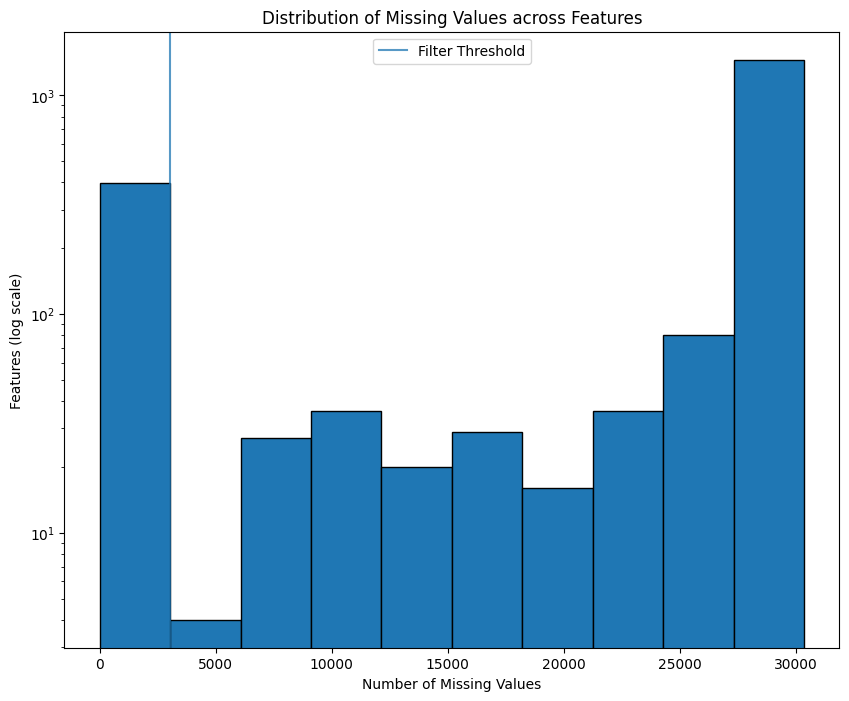

In [ ]:
# Calculate the number of missing values for each feature
logging.info('Calculating the number of missing values for each feature...')
missing_values = data_dta.isna().sum()
logging.info('Calculation of missing values completed.')

# Log some details about missing values
logging.info(f'Total features: {len(missing_values)}')
logging.info(f'Features with missing values: {missing_values[missing_values > 0].count()}')
logging.info(f'Features without missing values: {missing_values[missing_values == 0].count()}')

# Plotting
logging.info('Plotting the distribution of missing values across features...')
plt.figure(figsize=(10,8))
plt.hist(missing_values, edgecolor='black', log=True)  # Enable log scale on y-axis
plt.axvline(x=3050, alpha=0.75, label='Filter Threshold')
plt.xlabel('Number of Missing Values')
plt.ylabel('Features (log scale)')
plt.title('Distribution of Missing Values across Features')
plt.legend()
plt.show()
logging.info('Plotting completed.')

As evident, a significant number of features exhibited fewer than 3,050 missing values. Therefore, I adopted 3,050 as the threshold and focused on features with less than 3,050 missing values across all instances.

## Data Preprocessing

### Data Cleaning

In [ ]:
# Read DO file to get variable names/lines
logging.info('Reading DO file...')
with open(path_do, 'r') as file:
    do_file_lines = file.readlines()

# Extracting variable names/lines from DO file
logging.info('Extracting variable names from DO file...')
variable_lines = [x for x in do_file_lines if x.startswith('label variable')]
variable_names_dict = {x.split()[2]: x.split('\"')[1] for x in variable_lines if x.split()[2] in data_dta.columns}
logging.info(f'Extracted {len(variable_names_dict)} variable names from DO file.')

# Rename columns using variable names from DO file
logging.info('Renaming columns using variable names from DO file...')
data_dta = data_dta.rename(columns=variable_names_dict)
logging.info('Columns renamed.')

# Automate renaming columns
logging.info('Automating renaming of columns...')
data_dta.columns = [col.replace(' ', '_') for col in data_dta.columns]
logging.info('Columns renamed.')

# Remove columns with more than 3050 missing values
logging.info('Removing columns with more than 3050 missing values...')
initial_column_count = data_dta.shape[1]
data_dta.dropna(thresh=len(data_dta) - 3050, axis=1, inplace=True)
logging.info(f'Removed {initial_column_count - data_dta.shape[1]} columns with more than 3050 missing values.')

# Remove rows with any remaining missing values
logging.info('Removing rows with any remaining missing values...')
initial_row_count = data_dta.shape[0]
data_dta.dropna(inplace=True)
logging.info(f'Removed {initial_row_count - data_dta.shape[0]} rows with missing values.')

# Check final data shape
final_shape = data_dta.shape
logging.info(f'Final data shape: {final_shape}')
print(final_shape)

(20679, 396)


In [ ]:
# Check for any remaining NaN values in the dataset
logging.info('Checking for any remaining NaN values in the dataset...')
remaining_nan = data_dta.isnull().sum().sum()
if remaining_nan == 0:
    logging.info("No remaining NaN values in the dataset.")
    print("No remaining NaN values in the dataset.")
else:
    logging.warning(f"There are {remaining_nan} remaining NaN values in the dataset.")
    print(f"There are {remaining_nan} remaining NaN values in the dataset.")

# Identify and remove duplicate columns
logging.info('Identifying and removing duplicate columns...')
initial_column_count = data_dta.shape[1]
data_dta = data_dta.loc[:, ~data_dta.columns.duplicated()]
logging.info(f'Removed {initial_column_count - data_dta.shape[1]} duplicate columns.')

# Check final data shape
final_shape = data_dta.shape
logging.info(f'Final data shape: {final_shape}')
print(final_shape)

No remaining NaN values in the dataset.
(20679, 364)


In [ ]:
# Print and log list of all columns/variables/features after removing duplicates
logging.info("Printing list of all columns/variables/features after removing duplicates:")
print("List of all columns/variables/features:")
for col in data_dta.columns:
    logging.info(f'Column: {col}')
    print(col)

# Check final data shape
final_shape = data_dta.shape
logging.info(f'Final data shape: {final_shape}')
print(final_shape)

List of all columns/variables/features:
Case_Identification
Country_code_and_phase
Cluster_number
Household_number
Respondent's_line_number_(answering_Household_questionnaire)
Ultimate_area_unit
Household_sample_weight_(6_decimals)
Month_of_interview
Year_of_interview
Date_of_interview_(CMC)
Date_of_interview_Century_Day_Code_(CDC)
Number_of_household_members
Number_of_eligible_women_in_household
Number_of_eligible_men_in_household
Number_of_de_jure_members
Number_of_de_facto_members
Number_of_children_5_and_under_(de_jure)
Result_of_household_interview
Day_of_interview
Number_of_visits
Interviewer_identification
Ever-married_sample
Primary_sampling_unit
Sample_strata_for_sampling_errors
Stratification_used_in_sample_design
Region
Type_of_place_of_residence
Household_selected_for_male_interview
Household_weight_for_male_subsample_(6_decimals)
Field_supervisor
Number_of_eligible_children_for_height_and_weight
Cluster_altitude_in_meters
Total_adults_measured
Household_selected_for_hemogl

As we can see there are columns that are solely related to the logistics of the interview, such as its date, duration, and language. These will be dropped early on this point.

In [ ]:
# Columns to remove
columns_to_remove = [
    'Case_Identification',
    'Country_code_and_phase',
    'Cluster_number',
    'Household_number',
    "Respondent's_line_number_(answering_Household_questionnaire)",
    'Ultimate_area_unit',
    'Household_sample_weight_(6_decimals)',
    'Month_of_interview',
    'Year_of_interview',
    'Date_of_interview_(CMC)',
    'Date_of_interview_Century_Day_Code_(CDC)',
    'Number_of_household_members',
    'Number_of_eligible_women_in_household',
    'Number_of_eligible_men_in_household',
    'Number_of_de_facto_members',
    'Result_of_household_interview',
    'Day_of_interview',
    'Number_of_visits',
    'Interviewer_identification',
    'Ever-married_sample',
    'Primary_sampling_unit',
    'Sample_strata_for_sampling_errors',
    'Stratification_used_in_sample_design',
    'Household_selected_for_male_interview',
    'Household_weight_for_male_subsample_(6_decimals)',
    'Field_supervisor',
    'Number_of_eligible_children_for_height_and_weight',
    'Cluster_altitude_in_meters',
    'Total_adults_measured',
    'Household_selected_for_hemoglobin',
    'Household_selected_for_Domestic_Violence_module',
    'Language_of_questionnaire',
    'Language_of_interview',
    'Native_language_of_respondent',
    'Translator_used',
    'Team_number',
    'Team_supervisor',
    'Time_interview_started_(hhmm_-_24_hour_clock)',
    'Time_interview_ended_(hhmm_-_24_hour_clock)',
    'Length_of_interview_in_minutes',
    'NA_-_Bar_code_for_HIV_blood_sample'
]

# Remove specified columns
logging.info('Removing specified columns...')
initial_column_count = data_dta.shape[1]
data_dta.drop(columns=columns_to_remove, inplace=True)
logging.info(f'Removed {initial_column_count - data_dta.shape[1]} specified columns.')

# Print and log list of remaining columns/variables/features
logging.info("Printing list of remaining columns/variables/features:")
print("List of remaining columns/variables/features:")
for col in data_dta.columns:
    logging.info(f'Column: {col}')
    print(col)

List of remaining columns/variables/features:
Number_of_de_jure_members
Number_of_children_5_and_under_(de_jure)
Region
Type_of_place_of_residence
Source_of_drinking_water
Water_for_drinking_not_sufficient_in_the_last_month
Time_to_get_to_water_source_(minutes)
Type_of_toilet_facility
Has_electricity
Has_radio
Has_television
Has_refrigerator
Has_bicycle
Has_motorcycle/scooter
Has_car/truck
Main_floor_material
Main_wall_material
Main_roof_material
Number_of_rooms_used_for_sleeping
Relationship_structure
Line_number_of_head_of_household
Sex_of_head_of_household
Age_of_head_of_household
Has_telephone_(land-line)
Type_of_cookstove
Share_toilet_with_other_households
Type_of_cooking_fuel
Place_where_household_members_wash_their_hands
Presence_of_water_at_hand_washing_place
Items_present:_Soap_or_detergent
Items_present:_Ash,_mud,_sand
Items_present:_None
Anything_done_to_water_to_make_safe_to_drink
Water_usually_treated_by:_boil
Water_usually_treated_by:_add_bleach/chlorine
Water_usually_tre

In [ ]:
final_shape = data_dta.shape
logging.info(f'Final data shape: {final_shape}')
print(final_shape)

(20679, 323)


### Encoding of Categorical Features

In [ ]:
# Select columns with non-numerical data
logging.info('Selecting columns with non-numerical data...')
non_numerical_columns = data_dta.select_dtypes(exclude=['number']).columns

# Check if there are non-numerical columns
if len(non_numerical_columns) > 0:
    # Output recommended encoding method for categorical features
    logging.info("Recommended encoding method for categorical features:")
    logging.info("- One-Hot Encoding: Use when the categorical feature has no inherent order and has low cardinality (few unique values).")
    logging.info("- Label Encoding: Use when the categorical feature has inherent order or when using tree-based models like Decision Trees or Random Forests.")
    logging.info("- Ordinal Encoding: Use when the categorical feature has inherent order and when using linear models like Logistic Regression.")
    print("Recommended encoding method for categorical features:")
    print("- One-Hot Encoding: Use when the categorical feature has no inherent order and has low cardinality (few unique values).")
    print("- Label Encoding: Use when the categorical feature has inherent order or when using tree-based models like Decision Trees or Random Forests.")
    print("- Ordinal Encoding: Use when the categorical feature has inherent order and when using linear models like Logistic Regression.")
else:
    logging.info("None - There are no categorical features in the dataset.")
    print("None - There are no categorical features in the dataset.")

None - There are no categorical features in the dataset.


### Features and Target Matrices Selection

In [ ]:
# Drop other wealth index columns
logging.info('Dropping other wealth index columns...')
data_dta.drop(columns=[
    'Wealth_index_factor_score_combined_(5_decimals)',
    'Wealth_index_for_urban/rural',
    'Wealth_index_factor_score_for_urban/rural_(5_decimals)'
], inplace=True)

# Confirm the changes
logging.info("Remaining columns after dropping other wealth index columns:")
logging.info(data_dta.columns)
print("Remaining columns after dropping other wealth index columns:")
print(data_dta.columns)

Remaining columns after dropping other wealth index columns:
Index(['Number_of_de_jure_members', 'Number_of_children_5_and_under_(de_jure)',
       'Region', 'Type_of_place_of_residence', 'Source_of_drinking_water',
       'Water_for_drinking_not_sufficient_in_the_last_month',
       'Time_to_get_to_water_source_(minutes)', 'Type_of_toilet_facility',
       'Has_electricity', 'Has_radio',
       ...
       'Ever_attended_school', 'Education', 'Level_of_education_attended',
       'Highest_grade_completed', 'Registered_in_PhilHealth',
       'Covered_by_GSIS,_SSS,_other', 'Health_insurance:_GSIS',
       'Health_insurance:_SSS',
       'Health_insurance:_Private_insurance_company/health_maintenance_organization',
       'Health_insurance:_Other'],
      dtype='object', length=320)


In [ ]:
# Define a dictionary to map numerical values to labels
wealth_index_mapping = {
    1: 'Poorest',
    2: 'Poorer',
    3: 'Middle',
    4: 'Richer',
    5: 'Richest'
}

# Map the numerical values to labels in the DataFrame
logging.info('Mapping numerical values to labels in the DataFrame...')
data_dta['Wealth_index_combined'] = data_dta['Wealth_index_combined'].map(wealth_index_mapping)

# Print the first few rows to verify the mapping
logging.info("First few rows after mapping Wealth index combined categories:")
logging.info(data_dta['Wealth_index_combined'].head())
print("First few rows after mapping Wealth index combined categories:")
print(data_dta['Wealth_index_combined'].head())

First few rows after mapping Wealth index combined categories:
6     Poorest
14    Poorest
15     Richer
19     Poorer
22    Poorest
Name: Wealth_index_combined, dtype: object


## Data Partitioning

In [ ]:
# Separate features (X) and target variable (y)
logging.info('Separating features and target variable...')
X = data_dta.drop(columns=['Wealth_index_combined'])
y = data_dta['Wealth_index_combined']

# Split data into training and testing sets (80% train, 20% test)
logging.info('Splitting data into training and testing sets...')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create stratified validation set (10% of training set)
logging.info('Creating stratified validation set...')
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, val_index in stratified_split.split(X_train, y_train):
    X_train, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

# Print the shapes of the resulting datasets
logging.info("Shapes of the resulting datasets:")
logging.info("Training set shape: %s, %s", X_train.shape, y_train.shape)
logging.info("Validation set shape: %s, %s", X_val.shape, y_val.shape)
logging.info("Testing set shape: %s, %s", X_test.shape, y_test.shape)
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (14888, 319) (14888,)
Validation set shape: (1655, 319) (1655,)
Testing set shape: (4136, 319) (4136,)


## Feature Scaling

In [ ]:
# Identify binary, ordinal, and numerical features
binary_features = X_train.nunique()[X_train.nunique() == 2].index.tolist()
ordinal_features = [col for col in X_train.columns if 3 <= X_train[col].nunique() <= 10]
numerical_features = [col for col in X_train.columns if col not in binary_features + ordinal_features]

# Standardize numerical features
logging.info('Standardizing numerical features...')
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Scale ordinal features if ranges vary significantly (example: using StandardScaler)
logging.info('Scaling ordinal features if ranges vary significantly...')
ordinal_scaler = StandardScaler()
X_train[ordinal_features] = ordinal_scaler.fit_transform(X_train[ordinal_features])
X_val[ordinal_features] = ordinal_scaler.transform(X_val[ordinal_features])
X_test[ordinal_features] = ordinal_scaler.transform(X_test[ordinal_features])

## Feature Selection

In [ ]:
# Print the number of columns in the DataFrame
num_columns = X_train.shape[1]
logging.info("Number of columns: %s", num_columns)
print("Number of columns:", num_columns)

Number of columns: 319


At present, there are 319 features. However, an excessive number of features can often have adverse effects. This situation may result in overfitting which auses the model to become excessively tailored to the training data and perform poorly on new datasets. Therefore, we will do featre selection.

#### SelectFromModel

`SelectFromModel` is a feature selection method in Python's scikit-learn library. It selects features based on the importance weights assigned to them by an underlying estimator, such as a tree-based model, allowing for the automatic selection of the most relevant features for predictive modeling.

In [ ]:
# Function to clean feature names
def clean_feature_names(df):
    df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
    return df

# Clean the feature names in the training, test, and validation sets
X_train_final_cleaned = clean_feature_names(X_train)
X_test_final_cleaned = clean_feature_names(X_test)
X_val_final_cleaned = clean_feature_names(X_val)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

In [ ]:
# Define classifiers with importance getters
classifiers = {
    "AdaBoost": ("coef_", AdaBoostClassifier()),
    "Gradient Boosting": ("feature_importances_", GradientBoostingClassifier()),
    "CatBoost": (None, CatBoostClassifier()),  # CatBoost doesn't expose feature importances directly
    "LightGBM": ("feature_importances_", LGBMClassifier()),
    "XGBoost": ("feature_importances_", XGBClassifier(objective='multi:softprob', num_class=len(label_encoder.classes_)))
}

# Initialize lists to store selected features for each model
selected_features = {clf_name: [] for clf_name in classifiers.keys()}

# Iterate through each classifier
for clf_name, (importance_type, clf) in classifiers.items():
    logging.info("Selecting features for %s...", clf_name)
    # Define and fit the pipeline on train data
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        (clf_name, clf)
    ])
    pipeline.fit(X_train_final_cleaned, y_train_encoded)

    # Perform feature selection only on train data
    if importance_type and hasattr(clf, importance_type):
        selector = SelectFromModel(clf, prefit=True)
        selected_idx = selector.get_support(indices=True)
        selected_features[clf_name] = selected_idx.tolist()
    else:
        # If the model does not support feature importances or coefficients, include all features
        selected_features[clf_name] = list(range(X_train_final_cleaned.shape[1]))

    # Apply selected features to val data using only the scaler transformation
    X_val_transformed = pipeline.named_steps['scaler'].transform(X_val_final_cleaned)
    if importance_type and hasattr(clf, importance_type):
        X_val_selected = selector.transform(X_val_transformed)
    else:
        X_val_selected = X_val_transformed

# Now, let's check for mutual features
mutual_features = set(selected_features[next(iter(classifiers.keys()))])
for feature_set in selected_features.values():
    mutual_features = mutual_features.intersection(feature_set)

# Print mutual features
logging.info("Mutual features: %s", mutual_features)
print("Mutual features:", mutual_features)
logging.info('Feature selection process completed.')

Learning rate set to 0.090811
0:	learn: 1.4681364	total: 249ms	remaining: 4m 9s
1:	learn: 1.3661452	total: 428ms	remaining: 3m 33s
2:	learn: 1.2785450	total: 628ms	remaining: 3m 28s
3:	learn: 1.2060137	total: 828ms	remaining: 3m 26s
4:	learn: 1.1479556	total: 1.02s	remaining: 3m 23s
5:	learn: 1.0978173	total: 1.22s	remaining: 3m 21s
6:	learn: 1.0496534	total: 1.41s	remaining: 3m 20s
7:	learn: 1.0077330	total: 1.61s	remaining: 3m 19s
8:	learn: 0.9708348	total: 1.8s	remaining: 3m 18s
9:	learn: 0.9370562	total: 2.01s	remaining: 3m 19s
10:	learn: 0.9044948	total: 2.21s	remaining: 3m 18s
11:	learn: 0.8770025	total: 2.4s	remaining: 3m 17s
12:	learn: 0.8522880	total: 2.59s	remaining: 3m 16s
13:	learn: 0.8314795	total: 2.78s	remaining: 3m 15s
14:	learn: 0.8092749	total: 2.95s	remaining: 3m 13s
15:	learn: 0.7903018	total: 3.12s	remaining: 3m 11s
16:	learn: 0.7739586	total: 3.3s	remaining: 3m 10s
17:	learn: 0.7570937	total: 3.48s	remaining: 3m 10s
18:	learn: 0.7410624	total: 3.66s	remaining: 3m 

In [ ]:
# Mapping mutual feature indices to names
mutual_feature_names = [X_train_final_cleaned.columns[idx] for idx in mutual_features]
logging.info("Names of Mutual Features: %s", mutual_feature_names)
print("Names of Mutual Features:", mutual_feature_names)

# Initialize a dictionary to count the frequency of each feature index across all classifiers
feature_frequency = {}

# Populate the frequency dictionary
for feature_list in selected_features.values():
    for feature_index in feature_list:
        if feature_index in feature_frequency:
            feature_frequency[feature_index] += 1
        else:
            feature_frequency[feature_index] = 1

# Create a sorted list of features based on their frequency, highest frequency first
sorted_features_by_frequency = sorted(feature_frequency.items(), key=lambda item: item[1], reverse=True)

# Mapping indices to names and their frequencies
sorted_features_by_frequency_named = [(X_train_final_cleaned.columns[idx], freq) for idx, freq in sorted_features_by_frequency]

# Print the sorted features by frequency
logging.info("Features ranked by frequency:")
print("Features ranked by frequency:")
for feature, freq in sorted_features_by_frequency_named:
    logging.info("%s: %s", feature, freq)
    print(f"{feature}: {freq}")

logging.info('Feature analysis completed.')

Names of Mutual Features: ['Source_of_drinking_water', 'Type_of_toilet_facility', 'Has_television', 'Has_refrigerator', 'Has_bicycle', 'Has_motorcyclescooter', 'Has_cartruck', 'Main_floor_material', 'Main_wall_material', 'Main_roof_material', 'Has_telephone_landline', 'Type_of_cookstove', 'Share_toilet_with_other_households', 'Type_of_cooking_fuel', 'Location_of_toilet_facility', 'Has_watch', 'Has_a_computer', 'Has_bank_account', 'Type_of_light_at_home', 'Washing_machine', 'Air_conditioner', 'Gas_rangestove_with_oven', 'Microwavetoaster_oven', 'Audio_componentkaraoke', 'Cable_services', 'Tenure_status_of_the_housing_unit']
Features ranked by frequency:
Source_of_drinking_water: 5
Type_of_toilet_facility: 5
Has_television: 5
Has_refrigerator: 5
Has_bicycle: 5
Has_motorcyclescooter: 5
Has_cartruck: 5
Main_floor_material: 5
Main_wall_material: 5
Main_roof_material: 5
Has_telephone_landline: 5
Type_of_cookstove: 5
Share_toilet_with_other_households: 5
Type_of_cooking_fuel: 5
Location_of_to

In [ ]:
# Filter features with at least 3 frequency
filtered_features = [(feature, freq) for feature, freq in sorted_features_by_frequency_named if freq >= 3]
logging.info("Features with at least 3 frequency:")
print("Features with at least 3 frequency:")
for feature, freq in filtered_features:
    logging.info("%s: %s", feature, freq)
    print(f"{feature}: {freq}")

# Count how many features have at least 3 frequency
num_features_with_3_freq = len(filtered_features)
logging.info("Number of features with at least 3 frequency: %s", num_features_with_3_freq)
print("Number of features with at least 3 frequency:", num_features_with_3_freq)

logging.info('Feature filtering completed.')

Features with at least 3 frequency:
Source_of_drinking_water: 5
Type_of_toilet_facility: 5
Has_television: 5
Has_refrigerator: 5
Has_bicycle: 5
Has_motorcyclescooter: 5
Has_cartruck: 5
Main_floor_material: 5
Main_wall_material: 5
Main_roof_material: 5
Has_telephone_landline: 5
Type_of_cookstove: 5
Share_toilet_with_other_households: 5
Type_of_cooking_fuel: 5
Location_of_toilet_facility: 5
Has_watch: 5
Has_a_computer: 5
Has_bank_account: 5
Type_of_light_at_home: 5
Washing_machine: 5
Air_conditioner: 5
Gas_rangestove_with_oven: 5
Microwavetoaster_oven: 5
Audio_componentkaraoke: 5
Cable_services: 5
Tenure_status_of_the_housing_unit: 5
Type_of_place_of_residence: 4
Time_to_get_to_water_source_minutes: 4
Has_electricity: 4
Number_of_rooms_used_for_sleeping: 4
Has_mobile_telephone: 4
Mobile_phone_used_financial_transactions: 4
Induction_stove: 4
DVD_player: 4
Beneficiary_of_Pantawid_Pamilyang_Pilipino_program_4Ps: 4
Observed_place_for_handwashing: 4
Number_of_de_jure_members: 3
Region: 3
Has

#### Correlation Analysis

Next, we perform correlation analysis on features selected through SelectFromModel(), ensuring they have at least 4 occurrences. This step is crucial as some of the existing features exhibit high correlations, which could potentially exacerbate overfitting issues within the model.

In [ ]:
feature_names = X.columns.tolist()

# Filter features by minimum frequency
min_frequency = 4
high_freq_features = [feature_names[idx] for idx, freq in feature_frequency.items() if freq >= min_frequency]

# Compute the correlation matrix for the selected features
correlation_matrix = X[high_freq_features].corr()

# Find highly correlated pairs of features
features_to_remove = set()
correlation_threshold = 0.8  # Set the threshold for high correlation

for feature1 in correlation_matrix.columns:
    for feature2 in correlation_matrix.columns:
        if feature1 != feature2 and abs(correlation_matrix.loc[feature1, feature2]) >= correlation_threshold:
            # Compare frequencies and choose the one with lower frequency to recommend for removal
            freq1 = feature_frequency[feature_names.index(feature1)]
            freq2 = feature_frequency[feature_names.index(feature2)]
            feature_to_remove = feature2 if freq1 > freq2 else feature1
            features_to_remove.add(feature_to_remove)

# Output the recommendations
logging.info("Features recommended to be removed due to high correlation: %s", features_to_remove)
print("Features recommended to be removed due to high correlation:", features_to_remove)
logging.info("Total number of features recommended for removal: %s", len(features_to_remove))
print("Total number of features recommended for removal:", len(features_to_remove))

Features recommended to be removed due to high correlation: set()
Total number of features recommended for removal: 0


In [ ]:
# Filter features with at least 4 frequency and not in the features_to_remove list
filtered_features = [(feature, freq) for feature, freq in sorted_features_by_frequency_named if freq >= 4 and feature not in features_to_remove]

# Print the filtered features
logging.info("Features with at least 4 frequency and not recommended to be removed:")
print("Features with at least 4 frequency and not recommended to be removed:")
for feature, freq in filtered_features:
    logging.info("%s: %s", feature, freq)
    print(f"{feature}: {freq}")

# Count how many features have at least 4 frequency and not recommended to be removed
num_features_with_4_freq = len(filtered_features)
logging.info("Number of features with at least 4 frequency and not recommended to be removed: %s", num_features_with_4_freq)
print("Number of features with at least 4 frequency and not recommended to be removed:", num_features_with_4_freq)

Features with at least 4 frequency and not recommended to be removed:
Source_of_drinking_water: 5
Type_of_toilet_facility: 5
Has_television: 5
Has_refrigerator: 5
Has_bicycle: 5
Has_motorcyclescooter: 5
Has_cartruck: 5
Main_floor_material: 5
Main_wall_material: 5
Main_roof_material: 5
Has_telephone_landline: 5
Type_of_cookstove: 5
Share_toilet_with_other_households: 5
Type_of_cooking_fuel: 5
Location_of_toilet_facility: 5
Has_watch: 5
Has_a_computer: 5
Has_bank_account: 5
Type_of_light_at_home: 5
Washing_machine: 5
Air_conditioner: 5
Gas_rangestove_with_oven: 5
Microwavetoaster_oven: 5
Audio_componentkaraoke: 5
Cable_services: 5
Tenure_status_of_the_housing_unit: 5
Type_of_place_of_residence: 4
Time_to_get_to_water_source_minutes: 4
Has_electricity: 4
Number_of_rooms_used_for_sleeping: 4
Has_mobile_telephone: 4
Mobile_phone_used_financial_transactions: 4
Induction_stove: 4
DVD_player: 4
Beneficiary_of_Pantawid_Pamilyang_Pilipino_program_4Ps: 4
Observed_place_for_handwashing: 4
Number o

In [ ]:
# Create a set to store the common filtered features
common_filtered_features = set()

# Find common filtered features for each dataset
for dataset_name, dataset in [("Training", X_train_final_cleaned), ("Testing", X_test_final_cleaned), ("Validation", X_val_final_cleaned)]:
    filtered_features = [feature for feature, freq in sorted_features_by_frequency_named
                         if freq >= 4 and feature not in features_to_remove and feature in dataset.columns]
    if not common_filtered_features:
        common_filtered_features = set(filtered_features)
    else:
        common_filtered_features.intersection_update(filtered_features)

# Convert the set to a sorted list
final_features = sorted(common_filtered_features)

# Print and log the final selected features
logging.info("Final selected features: %s", final_features)
print("Final selected features:", final_features)

Final selected features: ['Air_conditioner', 'Audio_componentkaraoke', 'Beneficiary_of_Pantawid_Pamilyang_Pilipino_program_4Ps', 'Cable_services', 'DVD_player', 'Gas_rangestove_with_oven', 'Has_a_computer', 'Has_bank_account', 'Has_bicycle', 'Has_cartruck', 'Has_electricity', 'Has_mobile_telephone', 'Has_motorcyclescooter', 'Has_refrigerator', 'Has_telephone_landline', 'Has_television', 'Has_watch', 'Induction_stove', 'Location_of_toilet_facility', 'Main_floor_material', 'Main_roof_material', 'Main_wall_material', 'Microwavetoaster_oven', 'Mobile_phone_used_financial_transactions', 'Number_of_rooms_used_for_sleeping', 'Observed_place_for_handwashing', 'Share_toilet_with_other_households', 'Source_of_drinking_water', 'Tenure_status_of_the_housing_unit', 'Time_to_get_to_water_source_minutes', 'Type_of_cooking_fuel', 'Type_of_cookstove', 'Type_of_light_at_home', 'Type_of_place_of_residence', 'Type_of_toilet_facility', 'Washing_machine']


In [ ]:
# Subset the datasets with the final features
X_train_final_subset = X_train_final_cleaned[final_features]
X_test_final_subset = X_test_final_cleaned[final_features]
X_val_final_subset = X_val_final_cleaned[final_features]

## SMOTE

In [ ]:
# Apply SMOTE on the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final_subset, y_train_encoded)

## Machine Learning

In [ ]:
# Define formulas with spacing
accuracy_formula = r"Accuracy = \frac{TP + TN}{TP + TN + FP + FN} \\[1em]"
precision_formula = r"Precision = \frac{TP}{TP + FP} \\[1em]"
recall_formula = r"Recall = \frac{TP}{TP + FN} \\[1em]"
f1_score_formula = r"F1\,Score = 2 \times \frac{Precision \times Recall}{Precision + Recall} \\[1em]"
confusion_matrix_formula = r"\text{Confusion Matrix:} \\ \begin{bmatrix} TP & FP \\ FN & TN \end{bmatrix} \\[1em]"
tpr_formula = r"\text{True Positive Rate (TPR) or Recall} = \frac{TP}{TP + FN} \\[1em]"
fpr_formula = r"\text{False Positive Rate (FPR)} = \frac{FP}{FP + TN}"

# Display formulas with spacing
display(Math(accuracy_formula))
display(Math(precision_formula))
display(Math(recall_formula))
display(Math(f1_score_formula))
display(Math(confusion_matrix_formula))
display(Math(tpr_formula))
display(Math(fpr_formula))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Adaptive Boosting (AdaBoost)

Training time (AdaBoost (pre-tuning)): 0.90 seconds
Testing time (AdaBoost (pre-tuning)): 0.03 seconds
Performance metrics (AdaBoost (pre-tuning)):
Accuracy: 0.7650
Precision: 0.8095
Recall: 0.7650
F1 Score: 0.7610
ROC-AUC: 0.8777
Confusion Matrix (AdaBoost (pre-tuning)):
[[307   6   0  24   0]
 [ 76 317   0   0   0]
 [  0 177 165   0   0]
 [ 41   0   0 258   2]
 [  0   0   0  63 219]]
Tuning time: 105.85 seconds
Best Hyperparameters: {'learning_rate': 0.5, 'n_estimators': 200}
Training time (AdaBoost (post-tuning)): 4.31 seconds
Testing time (AdaBoost (post-tuning)): 0.14 seconds
Performance metrics (AdaBoost (post-tuning)):
Accuracy: 0.8024
Precision: 0.8338
Recall: 0.8024
F1 Score: 0.8009
ROC-AUC: 0.8779
Confusion Matrix (AdaBoost (post-tuning)):
[[313   6   0  18   0]
 [ 63 330   0   0   0]
 [  0 147 195   0   0]
 [ 42   0   0 255   4]
 [  0   0   0  47 235]]


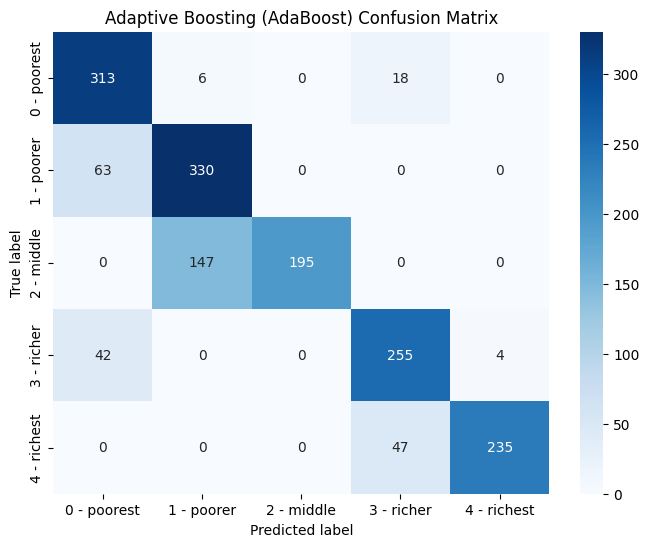

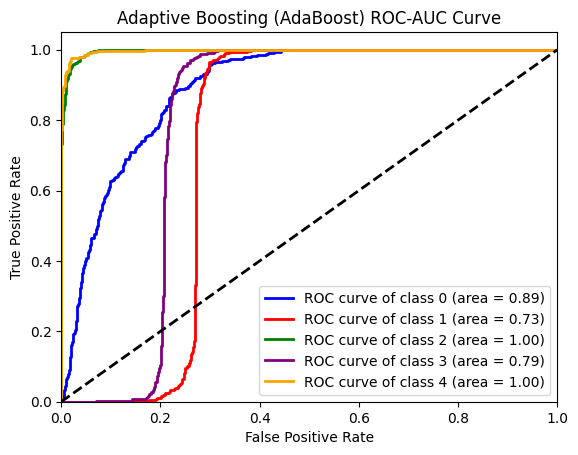

Total training time (pre-tuning): 0.90 seconds
Total testing time (pre-tuning): 0.03 seconds
Total tuning time: 105.85 seconds
Total training time (post-tuning): 4.31 seconds
Total testing time (post-tuning): 0.14 seconds
Testing time (AdaBoost on test data): 0.31 seconds
Performance metrics (AdaBoost on test data):
Accuracy: 0.8039
Precision: 0.8356
Recall: 0.8039
F1 Score: 0.8015
ROC-AUC: 0.8793
Confusion Matrix (AdaBoost on test data):
[[782  18   0  43   0]
 [134 849   0   0   0]
 [  0 377 476   0   0]
 [ 99   0   0 638  15]
 [  0   0   0 125 580]]


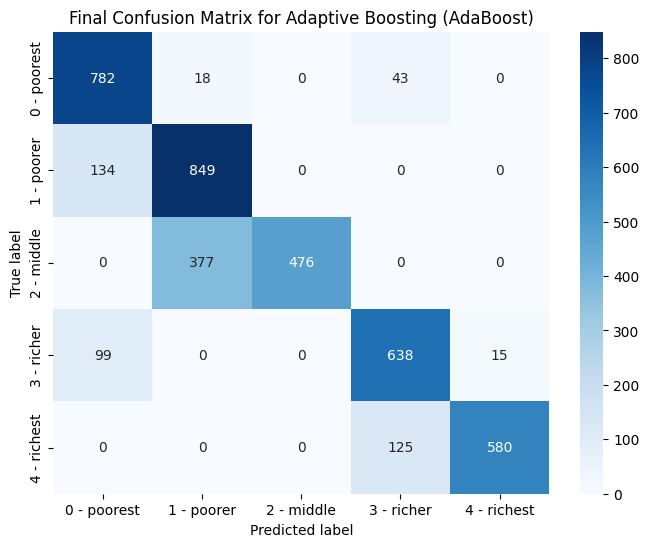

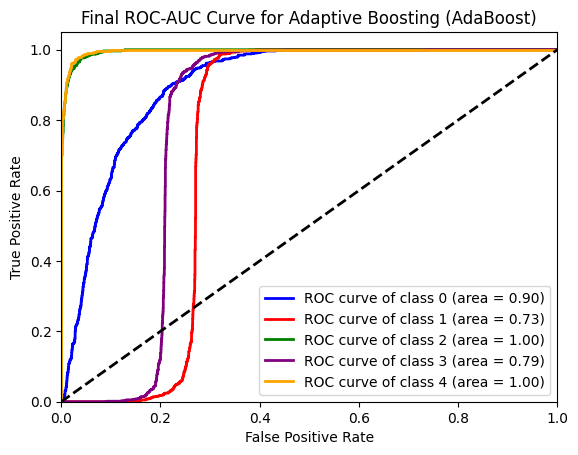

Total training time (pre-tuning): 0.90 seconds
Total testing time (pre-tuning): 0.03 seconds
Total tuning time: 105.85 seconds
Total training time (post-tuning): 4.31 seconds
Total testing time (post-tuning): 0.14 seconds
Total testing time (test data): 0.31 seconds


In [ ]:

def train_and_evaluate(clf, X_train, y_train, X_val, y_val, title):
    # Training phase
    start_time = time.time()
    clf.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Training time ({title}): {training_time:.2f} seconds")

    # Testing phase
    test_start_time = time.time()
    predictions = clf.predict(X_val)
    testing_time = time.time() - test_start_time
    print(f"Testing time ({title}): {testing_time:.2f} seconds")

    # Performance metrics
    metrics = {
        'Accuracy': accuracy_score(y_val, predictions),
        'Precision': precision_score(y_val, predictions, average='weighted'),
        'Recall': recall_score(y_val, predictions, average='weighted'),
        'F1 Score': f1_score(y_val, predictions, average='weighted'),
        'ROC-AUC': roc_auc_score(y_val, clf.predict_proba(X_val), multi_class='ovo')
    }

    print(f"Performance metrics ({title}):")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Confusion matrix
    conf_matrix = confusion_matrix(y_val, predictions)
    print(f"Confusion Matrix ({title}):\n{conf_matrix}")

    return metrics, conf_matrix, training_time, testing_time

# Initialize AdaBoost classifier
adaboost_clf = AdaBoostClassifier(random_state=42)

# Train and evaluate the model pre-tuning
metrics_pre, conf_matrix_pre, training_time_pre, testing_time_pre = train_and_evaluate(
    adaboost_clf, X_train_resampled, y_train_resampled, X_val_final_subset, y_val_encoded, "AdaBoost (pre-tuning)")

# Hyperparameter tuning
param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5]}
halving_grid_search = HalvingGridSearchCV(adaboost_clf, param_grid, cv=5, scoring='accuracy', factor=2, random_state=42)

tuning_start_time = time.time()
halving_grid_search.fit(X_train_resampled, y_train_resampled)
tuning_time = time.time() - tuning_start_time
print(f"Tuning time: {tuning_time:.2f} seconds")
print(f"Best Hyperparameters: {halving_grid_search.best_params_}")

# Train and evaluate the model post-tuning
best_clf = halving_grid_search.best_estimator_
metrics_post, conf_matrix_post, training_time_post, testing_time_post = train_and_evaluate(
    best_clf, X_train_resampled, y_train_resampled, X_val_final_subset, y_val_encoded, "AdaBoost (post-tuning)")

# Plot tuned Confusion Matrix with labels
plt.figure(figsize=(8, 6))
plt.title('Adaptive Boosting (AdaBoost) Confusion Matrix')
class_labels = ['0 - poorest', '1 - poorer', '2 - middle', '3 - richer', '4 - richest']
sns.heatmap(conf_matrix_post, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot ROC Curve for the best model
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_val_encoded == i, best_clf.predict_proba(X_val_final_subset)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Adaptive Boosting (AdaBoost) ROC-AUC Curve')
plt.legend(loc="lower right")
plt.show()

# Print total computational requirements
print(f"Total training time (pre-tuning): {training_time_pre:.2f} seconds")
print(f"Total testing time (pre-tuning): {testing_time_pre:.2f} seconds")
print(f"Total tuning time: {tuning_time:.2f} seconds")
print(f"Total training time (post-tuning): {training_time_post:.2f} seconds")
print(f"Total testing time (post-tuning): {testing_time_post:.2f} seconds")

# Evaluate the best model on the test data
test_start_time = time.time()
test_predictions = best_clf.predict(X_test_final_subset)
test_testing_time = time.time() - test_start_time
print(f"Testing time (AdaBoost on test data): {test_testing_time:.2f} seconds")

test_metrics = {
    'Accuracy': accuracy_score(y_test_encoded, test_predictions),
    'Precision': precision_score(y_test_encoded, test_predictions, average='weighted'),
    'Recall': recall_score(y_test_encoded, test_predictions, average='weighted'),
    'F1 Score': f1_score(y_test_encoded, test_predictions, average='weighted'),
    'ROC-AUC': roc_auc_score(y_test_encoded, best_clf.predict_proba(X_test_final_subset), multi_class='ovo')
}

print(f"Performance metrics (AdaBoost on test data):")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

test_conf_matrix = confusion_matrix(y_test_encoded, test_predictions)
print(f"Confusion Matrix (AdaBoost on test data):\n{test_conf_matrix}")

# Plot test Confusion Matrix with labels
plt.figure(figsize=(8, 6))
plt.title('Final Confusion Matrix for Adaptive Boosting (AdaBoost)')
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot ROC Curve for the test data
fpr_test = {}
tpr_test = {}
roc_auc_test = {}

for i in range(len(class_labels)):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_encoded == i, best_clf.predict_proba(X_test_final_subset)[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(fpr_test[i], tpr_test[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc_test[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC-AUC Curve for Adaptive Boosting (AdaBoost)')
plt.legend(loc="lower right")
plt.show()

# Print total computational requirements including test evaluation
print(f"Total training time (pre-tuning): {training_time_pre:.2f} seconds")
print(f"Total testing time (pre-tuning): {testing_time_pre:.2f} seconds")
print(f"Total tuning time: {tuning_time:.2f} seconds")
print(f"Total training time (post-tuning): {training_time_post:.2f} seconds")
print(f"Total testing time (post-tuning): {testing_time_post:.2f} seconds")
print(f"Total testing time (test data): {test_testing_time:.2f} seconds")

### Cat Boosting (CatBoost)

Training time (CatBoost (pre-tuning)): 62.09 seconds
Testing time (CatBoost (pre-tuning)): 0.01 seconds
Performance metrics (CatBoost (pre-tuning)):
Accuracy: 0.9088
Precision: 0.9086
Recall: 0.9088
F1 Score: 0.9086
ROC-AUC: 0.9924
Confusion Matrix (CatBoost (pre-tuning)):
[[288  20   0  29   0]
 [ 26 353  14   0   0]
 [  0  17 325   0   0]
 [ 16   0   0 266  19]
 [  0   0   0  10 272]]
Tuning time: 837.27 seconds
Best Hyperparameters: {'depth': 4, 'iterations': 300, 'learning_rate': 0.3}
Training time (CatBoost (post-tuning)): 4.86 seconds
Testing time (CatBoost (post-tuning)): 0.01 seconds
Performance metrics (CatBoost (post-tuning)):
Accuracy: 0.9100
Precision: 0.9099
Recall: 0.9100
F1 Score: 0.9098
ROC-AUC: 0.9926
Confusion Matrix (CatBoost (post-tuning)):
[[294  14   0  29   0]
 [ 29 347  17   0   0]
 [  0  20 322   0   0]
 [ 15   0   0 268  18]
 [  0   0   0   7 275]]


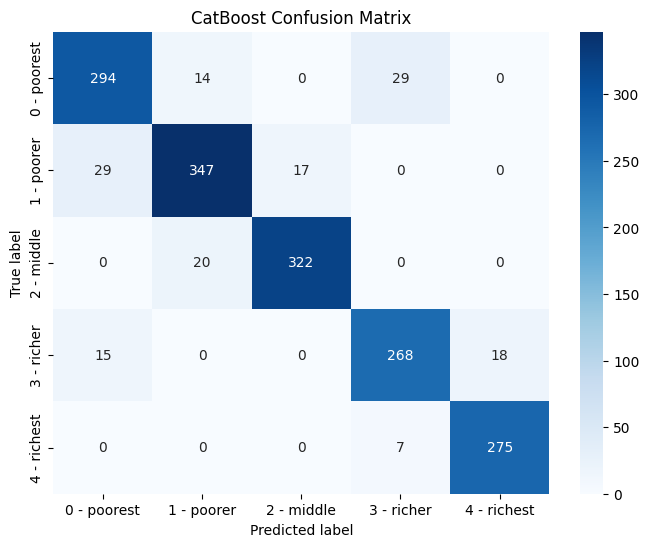

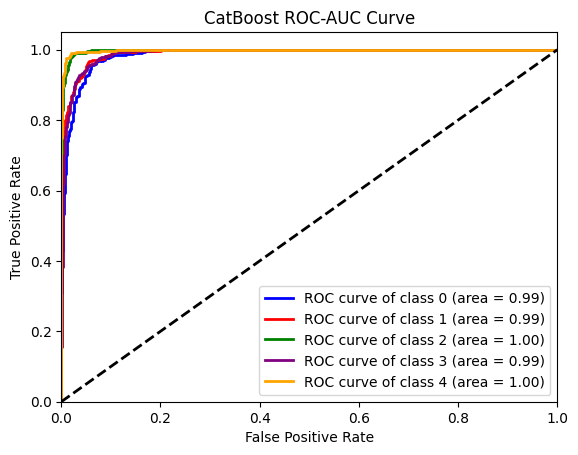

Total training time (pre-tuning): 62.09 seconds
Total testing time (pre-tuning): 0.01 seconds
Total tuning time: 837.27 seconds
Total training time (post-tuning): 4.86 seconds
Total testing time (post-tuning): 0.01 seconds
Testing time (CatBoost on test data): 0.03 seconds
Performance metrics (CatBoost on test data):
Accuracy: 0.9093
Precision: 0.9092
Recall: 0.9093
F1 Score: 0.9092
ROC-AUC: 0.9925
Confusion Matrix (CatBoost on test data):
[[744  39   0  60   0]
 [ 56 879  48   0   0]
 [  0  57 796   0   0]
 [ 42   0   0 660  50]
 [  0   0   0  23 682]]


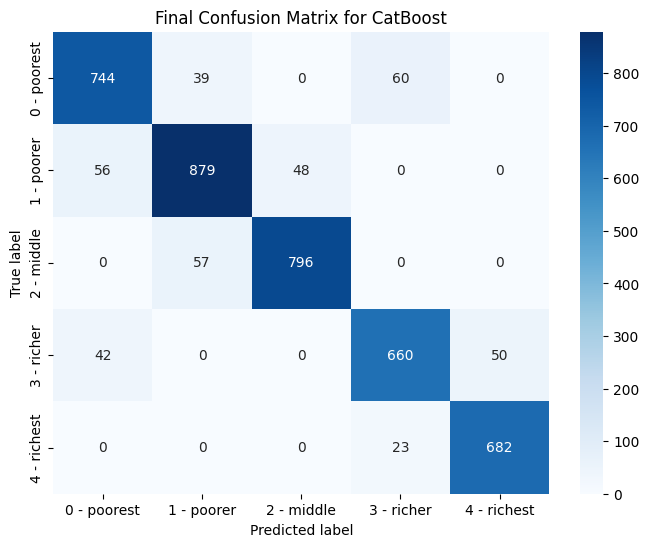

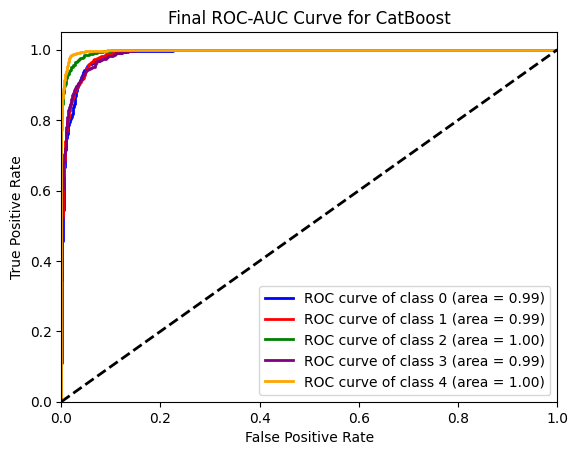

Total training time (pre-tuning): 62.09 seconds
Total testing time (pre-tuning): 0.01 seconds
Total tuning time: 837.27 seconds
Total training time (post-tuning): 4.86 seconds
Total testing time (post-tuning): 0.01 seconds
Total testing time (test data): 0.03 seconds


In [ ]:
def train_and_evaluate_catboost(clf, X_train, y_train, X_val, y_val, title):
    # Training phase
    start_time = time.time()
    clf.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Training time ({title}): {training_time:.2f} seconds")

    # Testing phase
    test_start_time = time.time()
    predictions = clf.predict(X_val)
    testing_time = time.time() - test_start_time
    print(f"Testing time ({title}): {testing_time:.2f} seconds")

    # Performance metrics
    metrics = {
        'Accuracy': accuracy_score(y_val, predictions),
        'Precision': precision_score(y_val, predictions, average='weighted'),
        'Recall': recall_score(y_val, predictions, average='weighted'),
        'F1 Score': f1_score(y_val, predictions, average='weighted'),
        'ROC-AUC': roc_auc_score(y_val, clf.predict_proba(X_val), multi_class='ovo')
    }

    print(f"Performance metrics ({title}):")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Confusion matrix
    conf_matrix = confusion_matrix(y_val, predictions)
    print(f"Confusion Matrix ({title}):\n{conf_matrix}")

    return metrics, conf_matrix, training_time, testing_time

# Initialize CatBoost classifier
catboost_model = CatBoostClassifier(random_state=42, verbose=0)

# Train and evaluate the model pre-tuning
metrics_catboost_pre, conf_matrix_catboost_pre, training_time_catboost_pre, testing_time_catboost_pre = train_and_evaluate_catboost(
    catboost_model, X_train_resampled, y_train_resampled, X_val_final_subset, y_val_encoded, "CatBoost (pre-tuning)")

# Hyperparameter tuning
param_grid_catboost = {'iterations': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.3], 'depth': [4, 6, 8]}
halving_grid_search_catboost = HalvingGridSearchCV(catboost_model, param_grid_catboost, cv=5, scoring='accuracy', factor=2, random_state=42)

tuning_start_time_catboost = time.time()
halving_grid_search_catboost.fit(X_train_resampled, y_train_resampled)
tuning_time_catboost = time.time() - tuning_start_time_catboost
print(f"Tuning time: {tuning_time_catboost:.2f} seconds")
print(f"Best Hyperparameters: {halving_grid_search_catboost.best_params_}")

# Train and evaluate the model post-tuning
best_catboost_model = halving_grid_search_catboost.best_estimator_
metrics_catboost_post, conf_matrix_catboost_post, training_time_catboost_post, testing_time_catboost_post = train_and_evaluate_catboost(
    best_catboost_model, X_train_resampled, y_train_resampled, X_val_final_subset, y_val_encoded, "CatBoost (post-tuning)")

# Plot tuned Confusion Matrix with labels
plt.figure(figsize=(8, 6))
plt.title('CatBoost Confusion Matrix')
class_labels = ['0 - poorest', '1 - poorer', '2 - middle', '3 - richer', '4 - richest']
sns.heatmap(conf_matrix_catboost_post, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot ROC Curve for the best model
fpr_catboost = {}
tpr_catboost = {}
roc_auc_catboost = {}

for i in range(len(class_labels)):
    fpr_catboost[i], tpr_catboost[i], _ = roc_curve(y_val_encoded == i, best_catboost_model.predict_proba(X_val_final_subset)[:, i])
    roc_auc_catboost[i] = auc(fpr_catboost[i], tpr_catboost[i])

plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(fpr_catboost[i], tpr_catboost[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc_catboost[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CatBoost ROC-AUC Curve')
plt.legend(loc="lower right")
plt.show()

# Print total computational requirements
print(f"Total training time (pre-tuning): {training_time_catboost_pre:.2f} seconds")
print(f"Total testing time (pre-tuning): {testing_time_catboost_pre:.2f} seconds")
print(f"Total tuning time: {tuning_time_catboost:.2f} seconds")
print(f"Total training time (post-tuning): {training_time_catboost_post:.2f} seconds")
print(f"Total testing time (post-tuning): {testing_time_catboost_post:.2f} seconds")

# Evaluate the best model on the test data
test_start_time_catboost = time.time()
test_predictions_catboost = best_catboost_model.predict(X_test_final_subset)
test_testing_time_catboost = time.time() - test_start_time_catboost
print(f"Testing time (CatBoost on test data): {test_testing_time_catboost:.2f} seconds")

test_metrics_catboost = {
    'Accuracy': accuracy_score(y_test_encoded, test_predictions_catboost),
    'Precision': precision_score(y_test_encoded, test_predictions_catboost, average='weighted'),
    'Recall': recall_score(y_test_encoded, test_predictions_catboost, average='weighted'),
    'F1 Score': f1_score(y_test_encoded, test_predictions_catboost, average='weighted'),
    'ROC-AUC': roc_auc_score(y_test_encoded, best_catboost_model.predict_proba(X_test_final_subset), multi_class='ovo')
}

print(f"Performance metrics (CatBoost on test data):")
for metric, value in test_metrics_catboost.items():
    print(f"{metric}: {value:.4f}")

test_conf_matrix_catboost = confusion_matrix(y_test_encoded, test_predictions_catboost)
print(f"Confusion Matrix (CatBoost on test data):\n{test_conf_matrix_catboost}")

# Plot test Confusion Matrix with labels
plt.figure(figsize=(8, 6))
plt.title('Final Confusion Matrix for CatBoost')
sns.heatmap(test_conf_matrix_catboost, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot ROC Curve for the test data
fpr_test_catboost = {}
tpr_test_catboost = {}
roc_auc_test_catboost = {}

for i in range(len(class_labels)):
    fpr_test_catboost[i], tpr_test_catboost[i], _ = roc_curve(y_test_encoded == i, best_catboost_model.predict_proba(X_test_final_subset)[:, i])
    roc_auc_test_catboost[i] = auc(fpr_test_catboost[i], tpr_test_catboost[i])

plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(fpr_test_catboost[i], tpr_test_catboost[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc_test_catboost[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC-AUC Curve for CatBoost')
plt.legend(loc="lower right")
plt.show()

# Print total computational requirements including test evaluation
print(f"Total training time (pre-tuning): {training_time_catboost_pre:.2f} seconds")
print(f"Total testing time (pre-tuning): {testing_time_catboost_pre:.2f} seconds")
print(f"Total tuning time: {tuning_time_catboost:.2f} seconds")
print(f"Total training time (post-tuning): {training_time_catboost_post:.2f} seconds")
print(f"Total testing time (post-tuning): {testing_time_catboost_post:.2f} seconds")
print(f"Total testing time (test data): {test_testing_time_catboost:.2f} seconds")

### Gradient Boosting Machine (GBM)



Training time (GBM (pre-tuning)): 16.53 seconds
Testing time (GBM (pre-tuning)): 0.03 seconds
Performance metrics (GBM (pre-tuning)):
Accuracy: 0.8296
Precision: 0.8290
Recall: 0.8296
F1 Score: 0.8290
ROC-AUC: 0.9718
Confusion Matrix (GBM (pre-tuning)):
[[237  46   0  54   0]
 [ 44 323  25   1   0]
 [  0  32 310   0   0]
 [ 33   0   0 239  29]
 [  0   0   0  18 264]]
Tuning time: 1841.68 seconds
Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300}
Training time (GBM (post-tuning)): 46.48 seconds
Testing time (GBM (post-tuning)): 0.07 seconds
Performance metrics (GBM (post-tuning)):
Accuracy: 0.8967
Precision: 0.8967
Recall: 0.8967
F1 Score: 0.8966
ROC-AUC: 0.9899
Confusion Matrix (GBM (post-tuning)):
[[291  19   0  27   0]
 [ 34 338  21   0   0]
 [  0  19 323   0   0]
 [ 20   1   0 262  18]
 [  0   0   0  12 270]]


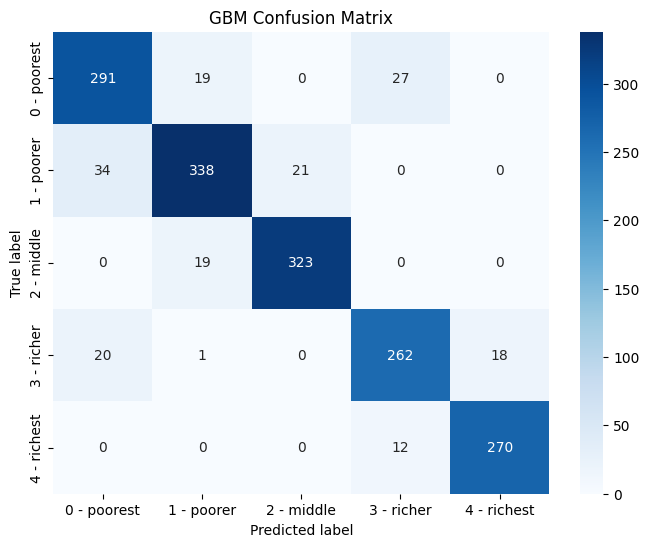

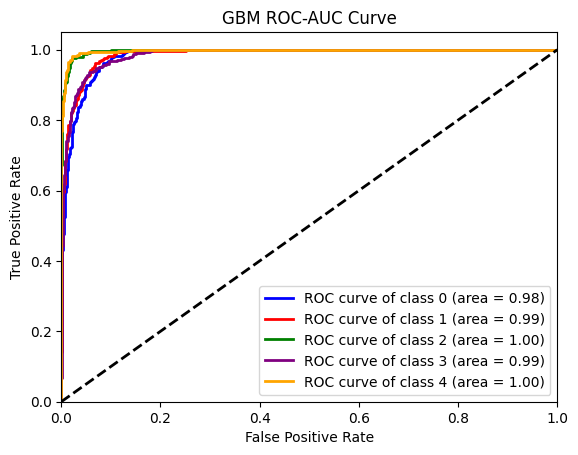

Total training time (pre-tuning): 16.53 seconds
Total testing time (pre-tuning): 0.03 seconds
Total tuning time: 1841.68 seconds
Total training time (post-tuning): 46.48 seconds
Total testing time (post-tuning): 0.07 seconds
Testing time (GBM on test data): 0.16 seconds
Performance metrics (GBM on test data):
Accuracy: 0.8905
Precision: 0.8904
Recall: 0.8905
F1 Score: 0.8904
ROC-AUC: 0.9898
Confusion Matrix (GBM on test data):
[[708  63   0  72   0]
 [ 60 871  52   0   0]
 [  0  60 793   0   0]
 [ 52   0   0 645  55]
 [  0   0   0  39 666]]


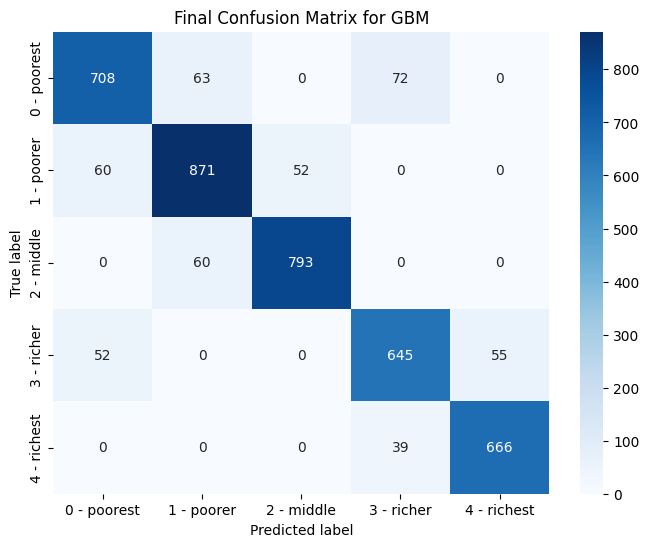

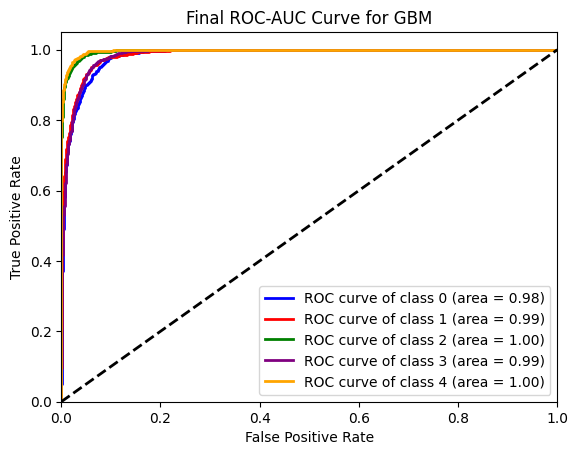

Total training time (pre-tuning): 16.53 seconds
Total testing time (pre-tuning): 0.03 seconds
Total tuning time: 1841.68 seconds
Total training time (post-tuning): 46.48 seconds
Total testing time (post-tuning): 0.07 seconds
Total testing time (test data): 0.16 seconds


In [ ]:
def train_and_evaluate_gbm(clf, X_train, y_train, X_val, y_val, title):
    # Training phase
    start_time = time.time()
    clf.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Training time ({title}): {training_time:.2f} seconds")

    # Testing phase
    test_start_time = time.time()
    predictions = clf.predict(X_val)
    testing_time = time.time() - test_start_time
    print(f"Testing time ({title}): {testing_time:.2f} seconds")

    # Performance metrics
    metrics = {
        'Accuracy': accuracy_score(y_val, predictions),
        'Precision': precision_score(y_val, predictions, average='weighted'),
        'Recall': recall_score(y_val, predictions, average='weighted'),
        'F1 Score': f1_score(y_val, predictions, average='weighted'),
        'ROC-AUC': roc_auc_score(y_val, clf.predict_proba(X_val), multi_class='ovo')
    }

    print(f"Performance metrics ({title}):")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Confusion matrix
    conf_matrix = confusion_matrix(y_val, predictions)
    print(f"Confusion Matrix ({title}):\n{conf_matrix}")

    return metrics, conf_matrix, training_time, testing_time

# Initialize Gradient Boosting classifier
gbm_model = GradientBoostingClassifier(random_state=42)

# Train and evaluate the model pre-tuning
metrics_gbm_pre, conf_matrix_gbm_pre, training_time_gbm_pre, testing_time_gbm_pre = train_and_evaluate_gbm(
    gbm_model, X_train_resampled, y_train_resampled, X_val_final_subset, y_val_encoded, "GBM (pre-tuning)")

# Hyperparameter tuning
param_grid_gbm = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.3], 'max_depth': [3, 4, 5]}
halving_grid_search_gbm = HalvingGridSearchCV(gbm_model, param_grid_gbm, cv=5, scoring='accuracy', factor=2, random_state=42)

tuning_start_time_gbm = time.time()
halving_grid_search_gbm.fit(X_train_resampled, y_train_resampled)
tuning_time_gbm = time.time() - tuning_start_time_gbm
print(f"Tuning time: {tuning_time_gbm:.2f} seconds")
print(f"Best Hyperparameters: {halving_grid_search_gbm.best_params_}")

# Train and evaluate the model post-tuning
best_gbm_model = halving_grid_search_gbm.best_estimator_
metrics_gbm_post, conf_matrix_gbm_post, training_time_gbm_post, testing_time_gbm_post = train_and_evaluate_gbm(
    best_gbm_model, X_train_resampled, y_train_resampled, X_val_final_subset, y_val_encoded, "GBM (post-tuning)")

# Plot tuned Confusion Matrix with labels
plt.figure(figsize=(8, 6))
plt.title('GBM Confusion Matrix')
class_labels = ['0 - poorest', '1 - poorer', '2 - middle', '3 - richer', '4 - richest']
sns.heatmap(conf_matrix_gbm_post, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot ROC Curve for the best model
fpr_gbm = {}
tpr_gbm = {}
roc_auc_gbm = {}

for i in range(len(class_labels)):
    fpr_gbm[i], tpr_gbm[i], _ = roc_curve(y_val_encoded == i, best_gbm_model.predict_proba(X_val_final_subset)[:, i])
    roc_auc_gbm[i] = auc(fpr_gbm[i], tpr_gbm[i])

plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(fpr_gbm[i], tpr_gbm[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc_gbm[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GBM ROC-AUC Curve')
plt.legend(loc="lower right")
plt.show()

# Print total computational requirements
print(f"Total training time (pre-tuning): {training_time_gbm_pre:.2f} seconds")
print(f"Total testing time (pre-tuning): {testing_time_gbm_pre:.2f} seconds")
print(f"Total tuning time: {tuning_time_gbm:.2f} seconds")
print(f"Total training time (post-tuning): {training_time_gbm_post:.2f} seconds")
print(f"Total testing time (post-tuning): {testing_time_gbm_post:.2f} seconds")

# Evaluate the best model on the test data
test_start_time_gbm = time.time()
test_predictions_gbm = best_gbm_model.predict(X_test_final_subset)
test_testing_time_gbm = time.time() - test_start_time_gbm
print(f"Testing time (GBM on test data): {test_testing_time_gbm:.2f} seconds")

test_metrics_gbm = {
    'Accuracy': accuracy_score(y_test_encoded, test_predictions_gbm),
    'Precision': precision_score(y_test_encoded, test_predictions_gbm, average='weighted'),
    'Recall': recall_score(y_test_encoded, test_predictions_gbm, average='weighted'),
    'F1 Score': f1_score(y_test_encoded, test_predictions_gbm, average='weighted'),
    'ROC-AUC': roc_auc_score(y_test_encoded, best_gbm_model.predict_proba(X_test_final_subset), multi_class='ovo')
}

print(f"Performance metrics (GBM on test data):")
for metric, value in test_metrics_gbm.items():
    print(f"{metric}: {value:.4f}")

test_conf_matrix_gbm = confusion_matrix(y_test_encoded, test_predictions_gbm)
print(f"Confusion Matrix (GBM on test data):\n{test_conf_matrix_gbm}")

# Plot test Confusion Matrix with labels
plt.figure(figsize=(8, 6))
plt.title('Final Confusion Matrix for GBM')
sns.heatmap(test_conf_matrix_gbm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot ROC Curve for the test data
fpr_test_gbm = {}
tpr_test_gbm = {}
roc_auc_test_gbm = {}

for i in range(len(class_labels)):
    fpr_test_gbm[i], tpr_test_gbm[i], _ = roc_curve(y_test_encoded == i, best_gbm_model.predict_proba(X_test_final_subset)[:, i])
    roc_auc_test_gbm[i] = auc(fpr_test_gbm[i], tpr_test_gbm[i])

plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(fpr_test_gbm[i], tpr_test_gbm[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc_test_gbm[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC-AUC Curve for GBM')
plt.legend(loc="lower right")
plt.show()

# Print total computational requirements including test evaluation
print(f"Total training time (pre-tuning): {training_time_gbm_pre:.2f} seconds")
print(f"Total testing time (pre-tuning): {testing_time_gbm_pre:.2f} seconds")
print(f"Total tuning time: {tuning_time_gbm:.2f} seconds")
print(f"Total training time (post-tuning): {training_time_gbm_post:.2f} seconds")
print(f"Total testing time (post-tuning): {testing_time_gbm_post:.2f} seconds")
print(f"Total testing time (test data): {test_testing_time_gbm:.2f} seconds")

### Light Gradient Boosting Machine (LightGBM)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

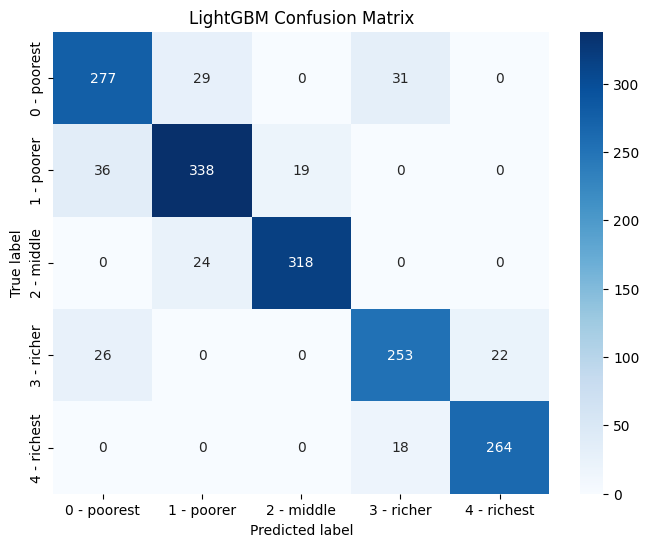

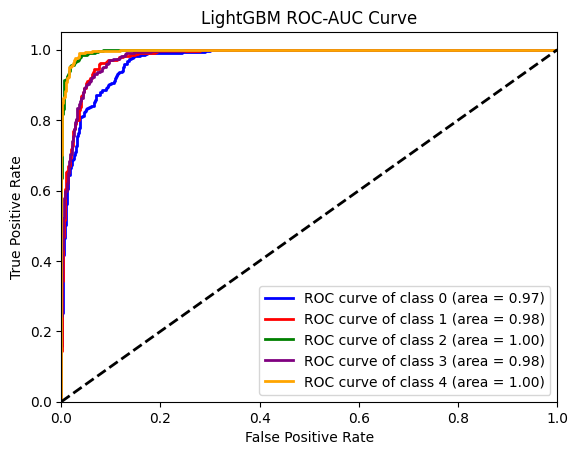

Total training time (pre-tuning): 2.59 seconds
Total testing time (pre-tuning): 0.06 seconds
Total tuning time: 402.65 seconds
Total training time (post-tuning): 4.13 seconds
Total testing time (post-tuning): 0.22 seconds
Testing time (LightGBM on test data): 0.52 seconds
Performance metrics (LightGBM on test data):
Accuracy: 0.8852
Precision: 0.8851
Recall: 0.8852
F1 Score: 0.8850
ROC-AUC: 0.9876
Confusion Matrix (LightGBM on test data):
[[701  73   0  69   0]
 [ 56 872  55   0   0]
 [  0  68 785   0   0]
 [ 56   2   0 637  57]
 [  0   0   0  39 666]]


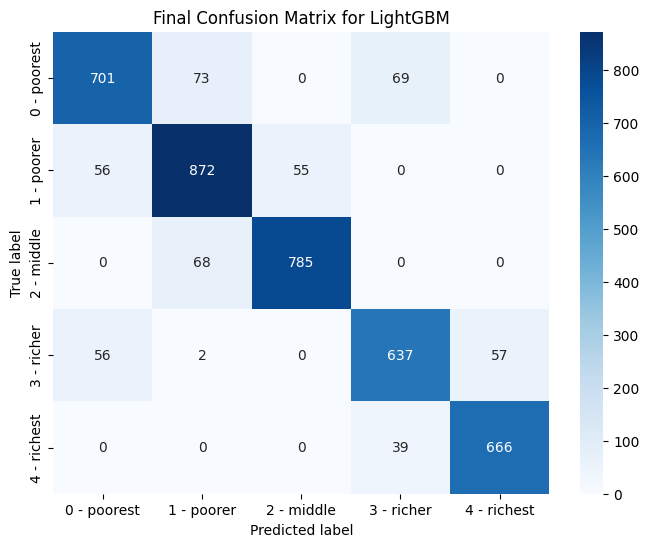

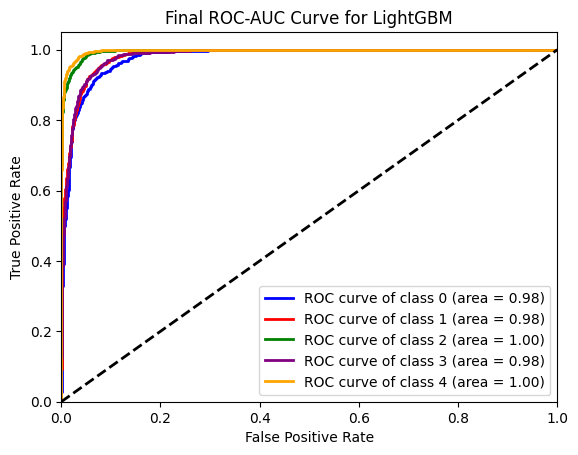

Total training time (pre-tuning): 2.59 seconds
Total testing time (pre-tuning): 0.06 seconds
Total tuning time: 402.65 seconds
Total training time (post-tuning): 4.13 seconds
Total testing time (post-tuning): 0.22 seconds
Total testing time (test data): 0.52 seconds


In [ ]:
def train_and_evaluate_lgb(clf, X_train, y_train, X_val, y_val, title):
    # Training phase
    start_time = time.time()
    clf.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Training time ({title}): {training_time:.2f} seconds")

    # Testing phase
    test_start_time = time.time()
    predictions = clf.predict(X_val)
    testing_time = time.time() - test_start_time
    print(f"Testing time ({title}): {testing_time:.2f} seconds")

    # Performance metrics
    metrics = {
        'Accuracy': accuracy_score(y_val, predictions),
        'Precision': precision_score(y_val, predictions, average='weighted'),
        'Recall': recall_score(y_val, predictions, average='weighted'),
        'F1 Score': f1_score(y_val, predictions, average='weighted'),
        'ROC-AUC': roc_auc_score(y_val, clf.predict_proba(X_val), multi_class='ovo')
    }

    print(f"Performance metrics ({title}):")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Confusion matrix
    conf_matrix = confusion_matrix(y_val, predictions)
    print(f"Confusion Matrix ({title}):\n{conf_matrix}")

    return metrics, conf_matrix, training_time, testing_time

# Initialize LightGBM classifier
lgb_model = lgb.LGBMClassifier(random_state=42)

# Train and evaluate the model pre-tuning
metrics_lgb_pre, conf_matrix_lgb_pre, training_time_lgb_pre, testing_time_lgb_pre = train_and_evaluate_lgb(
    lgb_model, X_train_resampled, y_train_resampled, X_val_final_subset, y_val_encoded, "LightGBM (pre-tuning)")

# Hyperparameter tuning
param_grid_lgb = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.3], 'num_leaves': [31, 40, 50]}
halving_grid_search_lgb = HalvingGridSearchCV(lgb_model, param_grid_lgb, cv=5, scoring='accuracy', factor=2, random_state=42)

tuning_start_time_lgb = time.time()
halving_grid_search_lgb.fit(X_train_resampled, y_train_resampled)
tuning_time_lgb = time.time() - tuning_start_time_lgb
print(f"Tuning time: {tuning_time_lgb:.2f} seconds")
print(f"Best Hyperparameters: {halving_grid_search_lgb.best_params_}")

# Train and evaluate the model post-tuning
best_lgb_model = halving_grid_search_lgb.best_estimator_
metrics_lgb_post, conf_matrix_lgb_post, training_time_lgb_post, testing_time_lgb_post = train_and_evaluate_lgb(
    best_lgb_model, X_train_resampled, y_train_resampled, X_val_final_subset, y_val_encoded, "LightGBM (post-tuning)")

# Plot tuned Confusion Matrix with labels
plt.figure(figsize=(8, 6))
plt.title('LightGBM Confusion Matrix')
class_labels = ['0 - poorest', '1 - poorer', '2 - middle', '3 - richer', '4 - richest']
sns.heatmap(conf_matrix_lgb_post, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot ROC Curve for the best model
fpr_lgb = {}
tpr_lgb = {}
roc_auc_lgb = {}

for i in range(len(class_labels)):
    fpr_lgb[i], tpr_lgb[i], _ = roc_curve(y_val_encoded == i, best_lgb_model.predict_proba(X_val_final_subset)[:, i])
    roc_auc_lgb[i] = auc(fpr_lgb[i], tpr_lgb[i])

plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(fpr_lgb[i], tpr_lgb[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc_lgb[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM ROC-AUC Curve')
plt.legend(loc="lower right")
plt.show()

# Print total computational requirements
print(f"Total training time (pre-tuning): {training_time_lgb_pre:.2f} seconds")
print(f"Total testing time (pre-tuning): {testing_time_lgb_pre:.2f} seconds")
print(f"Total tuning time: {tuning_time_lgb:.2f} seconds")
print(f"Total training time (post-tuning): {training_time_lgb_post:.2f} seconds")
print(f"Total testing time (post-tuning): {testing_time_lgb_post:.2f} seconds")

# Evaluate the best model on the test data
test_start_time_lgb = time.time()
test_predictions_lgb = best_lgb_model.predict(X_test_final_subset)
test_testing_time_lgb = time.time() - test_start_time_lgb
print(f"Testing time (LightGBM on test data): {test_testing_time_lgb:.2f} seconds")

test_metrics_lgb = {
    'Accuracy': accuracy_score(y_test_encoded, test_predictions_lgb),
    'Precision': precision_score(y_test_encoded, test_predictions_lgb, average='weighted'),
    'Recall': recall_score(y_test_encoded, test_predictions_lgb, average='weighted'),
    'F1 Score': f1_score(y_test_encoded, test_predictions_lgb, average='weighted'),
    'ROC-AUC': roc_auc_score(y_test_encoded, best_lgb_model.predict_proba(X_test_final_subset), multi_class='ovo')
}

print(f"Performance metrics (LightGBM on test data):")
for metric, value in test_metrics_lgb.items():
    print(f"{metric}: {value:.4f}")

test_conf_matrix_lgb = confusion_matrix(y_test_encoded, test_predictions_lgb)
print(f"Confusion Matrix (LightGBM on test data):\n{test_conf_matrix_lgb}")

# Plot test Confusion Matrix with labels
plt.figure(figsize=(8, 6))
plt.title('Final Confusion Matrix for LightGBM')
sns.heatmap(test_conf_matrix_lgb, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot ROC Curve for the test data
fpr_test_lgb = {}
tpr_test_lgb = {}
roc_auc_test_lgb = {}

for i in range(len(class_labels)):
    fpr_test_lgb[i], tpr_test_lgb[i], _ = roc_curve(y_test_encoded == i, best_lgb_model.predict_proba(X_test_final_subset)[:, i])
    roc_auc_test_lgb[i] = auc(fpr_test_lgb[i], tpr_test_lgb[i])

plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(fpr_test_lgb[i], tpr_test_lgb[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc_test_lgb[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC-AUC Curve for LightGBM')
plt.legend(loc="lower right")
plt.show()

# Print total computational requirements including test evaluation
print(f"Total training time (pre-tuning): {training_time_lgb_pre:.2f} seconds")
print(f"Total testing time (pre-tuning): {testing_time_lgb_pre:.2f} seconds")
print(f"Total tuning time: {tuning_time_lgb:.2f} seconds")
print(f"Total training time (post-tuning): {training_time_lgb_post:.2f} seconds")
print(f"Total testing time (post-tuning): {testing_time_lgb_post:.2f} seconds")
print(f"Total testing time (test data): {test_testing_time_lgb:.2f} seconds")


### Extreme Gradient Boosting (XGBoost)

Training time (XGBoost (pre-tuning)): 2.31 seconds
Testing time (XGBoost (pre-tuning)): 0.03 seconds
Performance metrics (XGBoost (pre-tuning)):
Accuracy: 0.8707
Precision: 0.8706
Recall: 0.8707
F1 Score: 0.8706
ROC-AUC: 0.9858
Confusion Matrix (XGBoost (pre-tuning)):
[[268  32   0  37   0]
 [ 35 338  20   0   0]
 [  0  24 318   0   0]
 [ 24   0   0 253  24]
 [  0   0   0  18 264]]
Tuning time: 275.40 seconds
Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300}
Training time (XGBoost (post-tuning)): 6.85 seconds
Testing time (XGBoost (post-tuning)): 0.03 seconds
Performance metrics (XGBoost (post-tuning)):
Accuracy: 0.8943
Precision: 0.8943
Recall: 0.8943
F1 Score: 0.8942
ROC-AUC: 0.9902
Confusion Matrix (XGBoost (post-tuning)):
[[284  24   0  29   0]
 [ 37 342  14   0   0]
 [  0  18 324   0   0]
 [ 22   0   0 258  21]
 [  0   0   0  10 272]]


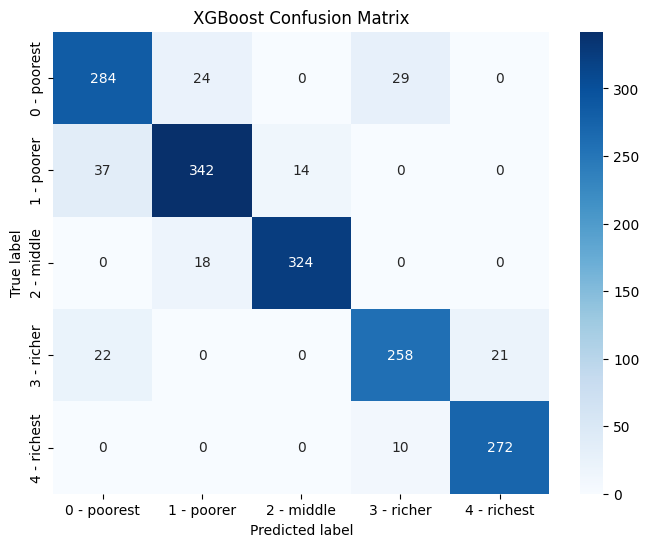

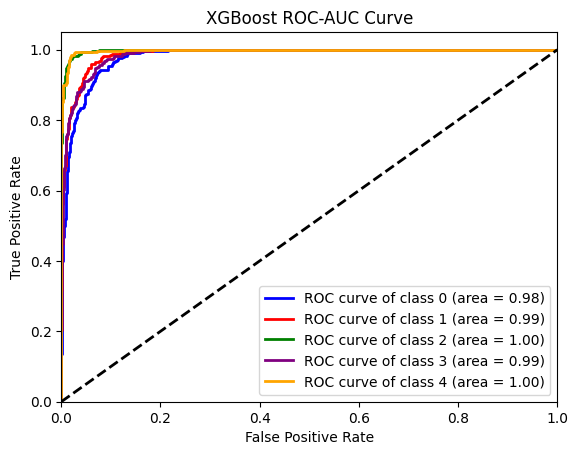

Total training time (pre-tuning): 2.31 seconds
Total testing time (pre-tuning): 0.03 seconds
Total tuning time: 275.40 seconds
Total training time (post-tuning): 6.85 seconds
Total testing time (post-tuning): 0.03 seconds
Testing time (XGBoost on test data): 0.07 seconds
Performance metrics (XGBoost on test data):
Accuracy: 0.8941
Precision: 0.8939
Recall: 0.8941
F1 Score: 0.8940
ROC-AUC: 0.9900
Confusion Matrix (XGBoost on test data):
[[721  56   0  66   0]
 [ 58 864  60   1   0]
 [  0  61 792   0   0]
 [ 50   0   0 652  50]
 [  0   0   0  36 669]]


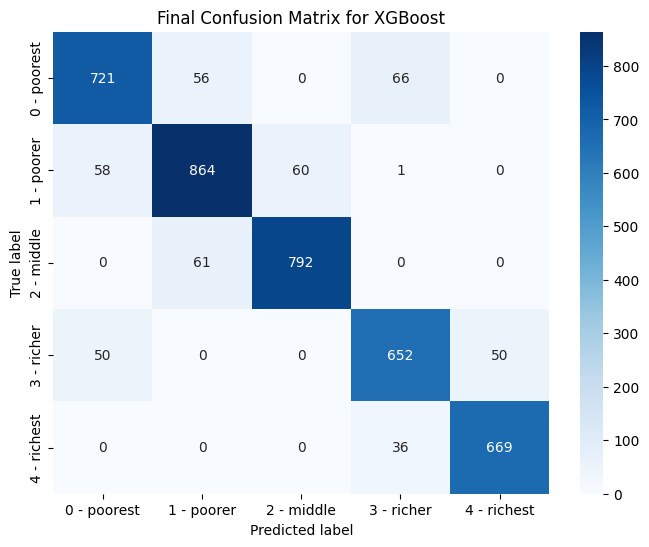

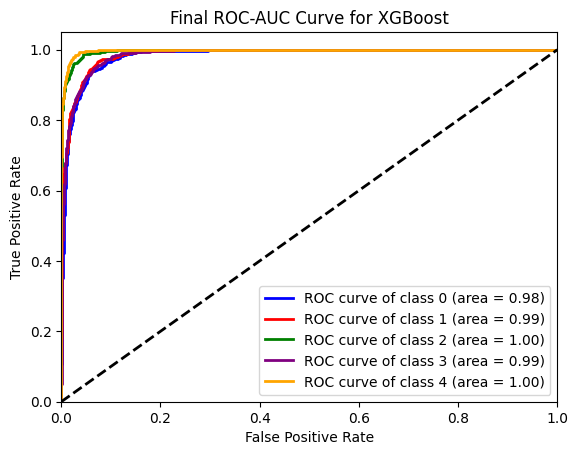

Total training time (pre-tuning): 2.31 seconds
Total testing time (pre-tuning): 0.03 seconds
Total tuning time: 275.40 seconds
Total training time (post-tuning): 6.85 seconds
Total testing time (post-tuning): 0.03 seconds
Total testing time (test data): 0.07 seconds


In [ ]:
def train_and_evaluate_xgb(clf, X_train, y_train, X_val, y_val, title):
    # Training phase
    start_time = time.time()
    clf.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Training time ({title}): {training_time:.2f} seconds")

    # Testing phase
    test_start_time = time.time()
    predictions = clf.predict(X_val)
    testing_time = time.time() - test_start_time
    print(f"Testing time ({title}): {testing_time:.2f} seconds")

    # Performance metrics
    metrics = {
        'Accuracy': accuracy_score(y_val, predictions),
        'Precision': precision_score(y_val, predictions, average='weighted'),
        'Recall': recall_score(y_val, predictions, average='weighted'),
        'F1 Score': f1_score(y_val, predictions, average='weighted'),
        'ROC-AUC': roc_auc_score(y_val, clf.predict_proba(X_val), multi_class='ovo')
    }

    print(f"Performance metrics ({title}):")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Confusion matrix
    conf_matrix = confusion_matrix(y_val, predictions)
    print(f"Confusion Matrix ({title}):\n{conf_matrix}")

    return metrics, conf_matrix, training_time, testing_time

# Initialize XGBoost classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Train and evaluate the model pre-tuning
metrics_xgb_pre, conf_matrix_xgb_pre, training_time_xgb_pre, testing_time_xgb_pre = train_and_evaluate_xgb(
    xgb_model, X_train_resampled, y_train_resampled, X_val_final_subset, y_val_encoded, "XGBoost (pre-tuning)")

# Hyperparameter tuning
param_grid_xgb = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.3], 'max_depth': [3, 4, 5]}
halving_grid_search_xgb = HalvingGridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='accuracy', factor=2, random_state=42)

tuning_start_time_xgb = time.time()
halving_grid_search_xgb.fit(X_train_resampled, y_train_resampled)
tuning_time_xgb = time.time() - tuning_start_time_xgb
print(f"Tuning time: {tuning_time_xgb:.2f} seconds")
print(f"Best Hyperparameters: {halving_grid_search_xgb.best_params_}")

# Train and evaluate the model post-tuning
best_xgb_model = halving_grid_search_xgb.best_estimator_
metrics_xgb_post, conf_matrix_xgb_post, training_time_xgb_post, testing_time_xgb_post = train_and_evaluate_xgb(
    best_xgb_model, X_train_resampled, y_train_resampled, X_val_final_subset, y_val_encoded, "XGBoost (post-tuning)")

# Plot tuned Confusion Matrix with labels
plt.figure(figsize=(8, 6))
plt.title('XGBoost Confusion Matrix')
class_labels = ['0 - poorest', '1 - poorer', '2 - middle', '3 - richer', '4 - richest']
sns.heatmap(conf_matrix_xgb_post, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot ROC Curve for the best model
fpr_xgb = {}
tpr_xgb = {}
roc_auc_xgb = {}

for i in range(len(class_labels)):
    fpr_xgb[i], tpr_xgb[i], _ = roc_curve(y_val_encoded == i, best_xgb_model.predict_proba(X_val_final_subset)[:, i])
    roc_auc_xgb[i] = auc(fpr_xgb[i], tpr_xgb[i])

plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(fpr_xgb[i], tpr_xgb[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc_xgb[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC-AUC Curve')
plt.legend(loc="lower right")
plt.show()

# Print total computational requirements
print(f"Total training time (pre-tuning): {training_time_xgb_pre:.2f} seconds")
print(f"Total testing time (pre-tuning): {testing_time_xgb_pre:.2f} seconds")
print(f"Total tuning time: {tuning_time_xgb:.2f} seconds")
print(f"Total training time (post-tuning): {training_time_xgb_post:.2f} seconds")
print(f"Total testing time (post-tuning): {testing_time_xgb_post:.2f} seconds")

# Evaluate the best model on the test data
test_start_time_xgb = time.time()
test_predictions_xgb = best_xgb_model.predict(X_test_final_subset)
test_testing_time_xgb = time.time() - test_start_time_xgb
print(f"Testing time (XGBoost on test data): {test_testing_time_xgb:.2f} seconds")

test_metrics_xgb = {
    'Accuracy': accuracy_score(y_test_encoded, test_predictions_xgb),
    'Precision': precision_score(y_test_encoded, test_predictions_xgb, average='weighted'),
    'Recall': recall_score(y_test_encoded, test_predictions_xgb, average='weighted'),
    'F1 Score': f1_score(y_test_encoded, test_predictions_xgb, average='weighted'),
    'ROC-AUC': roc_auc_score(y_test_encoded, best_xgb_model.predict_proba(X_test_final_subset), multi_class='ovo')
}

print(f"Performance metrics (XGBoost on test data):")
for metric, value in test_metrics_xgb.items():
    print(f"{metric}: {value:.4f}")

test_conf_matrix_xgb = confusion_matrix(y_test_encoded, test_predictions_xgb)
print(f"Confusion Matrix (XGBoost on test data):\n{test_conf_matrix_xgb}")

# Plot test Confusion Matrix with labels
plt.figure(figsize=(8, 6))
plt.title('Final Confusion Matrix for XGBoost')
sns.heatmap(test_conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot ROC Curve for the test data
fpr_test_xgb = {}
tpr_test_xgb = {}
roc_auc_test_xgb = {}

for i in range(len(class_labels)):
    fpr_test_xgb[i], tpr_test_xgb[i], _ = roc_curve(y_test_encoded == i, best_xgb_model.predict_proba(X_test_final_subset)[:, i])
    roc_auc_test_xgb[i] = auc(fpr_test_xgb[i], tpr_test_xgb[i])

plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(fpr_test_xgb[i], tpr_test_xgb[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc_test_xgb[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC-AUC Curve for XGBoost')
plt.legend(loc="lower right")
plt.show()

# Print total computational requirements including test evaluation
print(f"Total training time (pre-tuning): {training_time_xgb_pre:.2f} seconds")
print(f"Total testing time (pre-tuning): {testing_time_xgb_pre:.2f} seconds")
print(f"Total tuning time: {tuning_time_xgb:.2f} seconds")
print(f"Total training time (post-tuning): {training_time_xgb_post:.2f} seconds")
print(f"Total testing time (post-tuning): {testing_time_xgb_post:.2f} seconds")
print(f"Total testing time (test data): {test_testing_time_xgb:.2f} seconds")

## Data Visualization and Analysis

In [ ]:
import pandas as pd

# Create a dictionary to store the test results
test_results = {
    'Model': ['AdaBoost', 'CatBoost', 'GBM', 'LightGBM', 'XGBoost'],
    'Accuracy': [test_metrics['Accuracy'], test_metrics_catboost['Accuracy'], test_metrics_gbm['Accuracy'], test_metrics_lgb['Accuracy'], test_metrics_xgb['Accuracy']],
    'Precision': [test_metrics['Precision'], test_metrics_catboost['Precision'], test_metrics_gbm['Precision'], test_metrics_lgb['Precision'], test_metrics_xgb['Precision']],
    'Recall': [test_metrics['Recall'], test_metrics_catboost['Recall'], test_metrics_gbm['Recall'], test_metrics_lgb['Recall'], test_metrics_xgb['Recall']],
    'F1 Score': [test_metrics['F1 Score'], test_metrics_catboost['F1 Score'], test_metrics_gbm['F1 Score'], test_metrics_lgb['F1 Score'], test_metrics_xgb['F1 Score']],
    'ROC-AUC': [test_metrics['ROC-AUC'], test_metrics_catboost['ROC-AUC'], test_metrics_gbm['ROC-AUC'], test_metrics_lgb['ROC-AUC'], test_metrics_xgb['ROC-AUC']]
}

# Convert the dictionary to a DataFrame
test_results_df = pd.DataFrame(test_results)

# Print the table of metrics
print(test_results_df)

      Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0  AdaBoost  0.803917   0.835551  0.803917  0.801523  0.879285
1  CatBoost  0.909333   0.909193  0.909333  0.909191  0.992526
2       GBM  0.890474   0.890362  0.890474  0.890353  0.989841
3  LightGBM  0.885155   0.885137  0.885155  0.884996  0.987570
4   XGBoost  0.894101   0.893919  0.894101  0.893981  0.990004


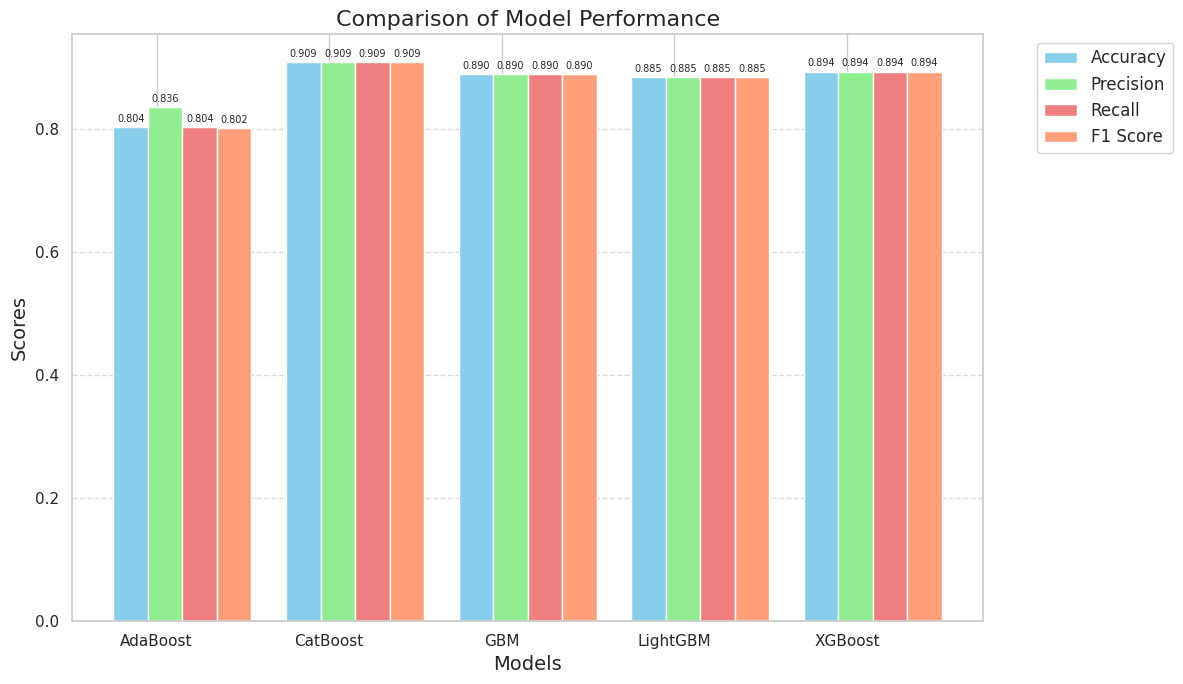

In [ ]:
# Enhanced Visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Colors for each metric
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon']

# Plot each metric as a bar with distinct colors
for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax.bar(x + i*width, metric, width, label=metrics_labels[i], color=color)

# Add value labels on top of each bar
for i in range(len(models)):
    for j in range(len(metrics)):
        ax.text(x[i] + j*width, metrics[j][i] + 0.005, f"{metrics[j][i]:.3f}", fontsize=7, ha='center', va='bottom')

# Add labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Comparison of Model Performance', fontsize=16)
ax.set_xticks(x + width * 1.5 / 2)
ax.set_xticklabels(models)
ax.legend(fontsize=12,bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


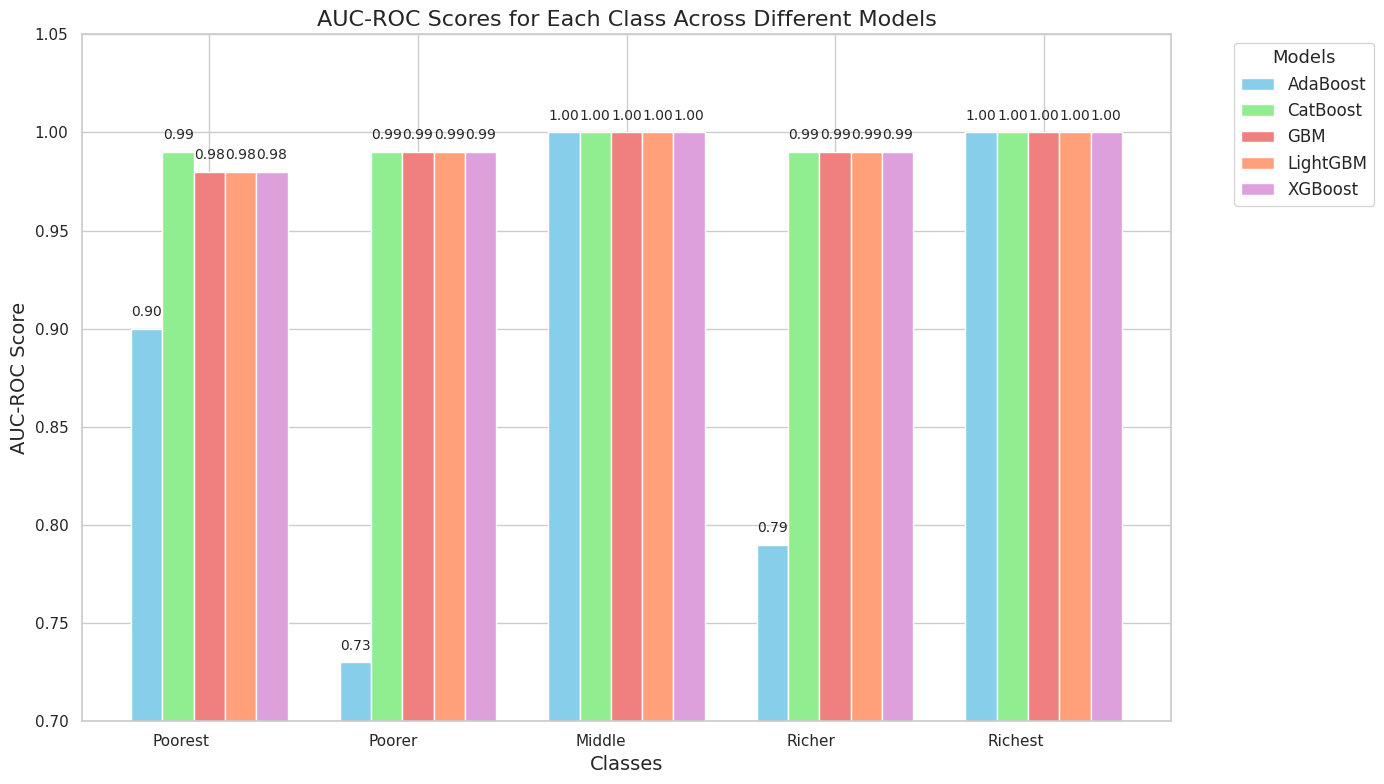

In [ ]:
# Improved visualization for the provided AUC-ROC scores

# Data
models = ['AdaBoost', 'CatBoost', 'GBM', 'LightGBM', 'XGBoost']
auc_roc_scores = [
    [0.90, 0.99, 0.98, 0.98, 0.98],
    [0.73, 0.99, 0.99, 0.99, 0.99],
    [1.00, 1.00, 1.00, 1.00, 1.00],
    [0.79, 0.99, 0.99, 0.99, 0.99],
    [1.00, 1.00, 1.00, 1.00, 1.00]
]
classes = ['Poorest', 'Poorer', 'Middle', 'Richer', 'Richest']

# Convert to numpy array for easier manipulation
auc_roc_scores = np.array(auc_roc_scores).T

# Enhanced visualization
fig, ax = plt.subplots(figsize=(14, 8))

# Colors matching the previous chart
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'plum']

# Plot each model's scores for each class
x = np.arange(len(classes))
width = 0.15

for i, (model_scores, color) in enumerate(zip(auc_roc_scores, colors)):
    ax.bar(x + i * width, model_scores, width, label=models[i], color=color)
    for j in range(len(classes)):
        ax.text(x[j] + i * width, model_scores[j] + 0.005, f"{model_scores[j]:.2f}", ha='center', va='bottom', fontsize=10)

# Add labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Classes', fontsize=14)
ax.set_ylabel('AUC-ROC Score', fontsize=14)
ax.set_title('AUC-ROC Scores for Each Class Across Different Models', fontsize=16)
ax.set_xticks(x + width * 2)
ax.set_xticklabels(classes, rotation=0, ha='right')
ax.set_ylim(0.7, 1.05)
ax.legend(title='Models', fontsize=12, title_fontsize='13' ,bbox_to_anchor=(1.05, 1), loc='upper left')


# Display the plot
plt.tight_layout()
plt.show()


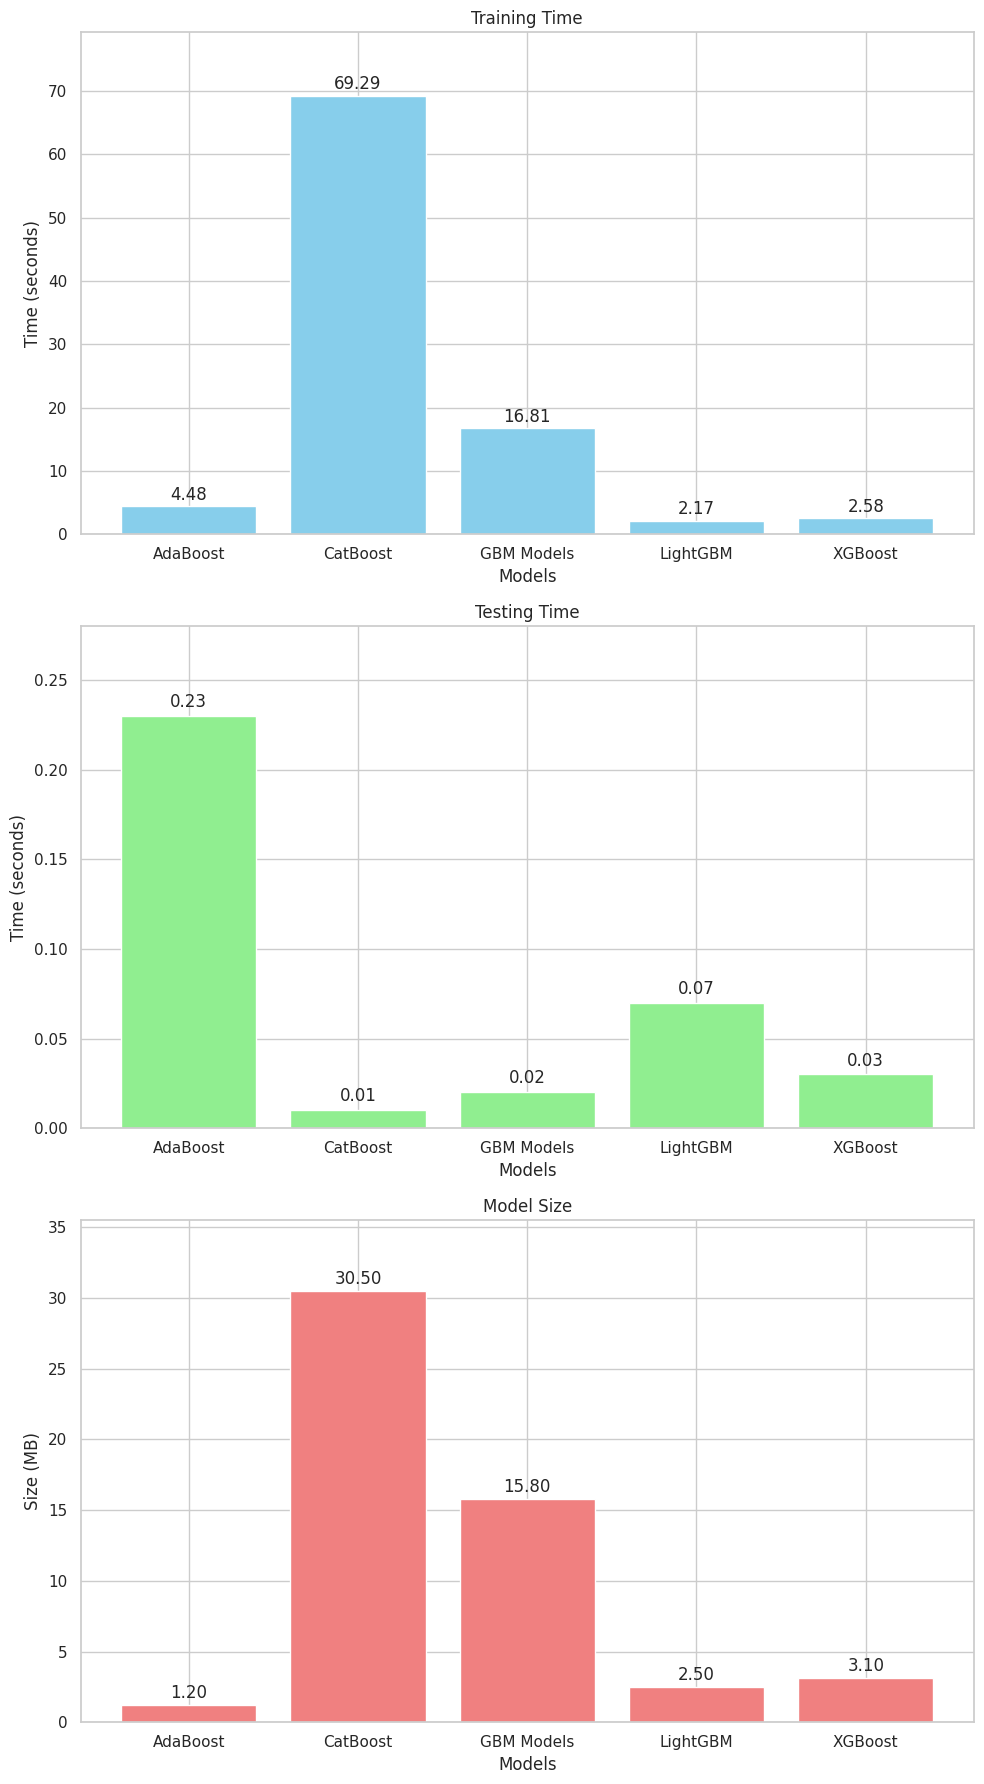

In [ ]:
# Plotting stacked vertically
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Training Time
axs[0].bar(models, training_time, color='skyblue')
axs[0].set_title('Training Time')
axs[0].set_ylabel('Time (seconds)')
axs[0].set_xlabel('Models')
axs[0].set_ylim(0, max(training_time) + 10)
for i, v in enumerate(training_time):
    axs[0].text(i, v + 1, f'{v:.2f}', ha='center')

# Testing Time
axs[1].bar(models, testing_time, color='lightgreen')
axs[1].set_title('Testing Time')
axs[1].set_ylabel('Time (seconds)')
axs[1].set_xlabel('Models')
axs[1].set_ylim(0, max(testing_time) + 0.05)
for i, v in enumerate(testing_time):
    axs[1].text(i, v + 0.005, f'{v:.2f}', ha='center')

# Model Size
axs[2].bar(models, model_size, color='lightcoral')
axs[2].set_title('Model Size')
axs[2].set_ylabel('Size (MB)')
axs[2].set_xlabel('Models')
axs[2].set_ylim(0, max(model_size) + 5)
for i, v in enumerate(model_size):
    axs[2].text(i, v + 0.5, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()
